## Summary: Choosing the Right Approach

| Approach | Pros | Cons | When to Use |
|----------|------|------|-------------|
| **Grid/Random Search** | Simple, interpretable, finds global optimum | Slow, requires multiple training runs | Small search space, need best possible config |
| **Differentiable (DARTS)** | Learns end-to-end, elegant | Complex, can be unstable | Research setting, want single training run |
| **Multi-Scale Ensemble** | **Best balance**, simple to integrate, interpretable | Larger model (trains all scales) | **Production/practical use** ⭐ |

### Recommendation for Your Case:

**Use Approach 3 (Multi-Scale Ensemble)** because:
- ✅ Drop-in replacement for your current architecture
- ✅ Learns optimal patch lengths automatically during training
- ✅ Can inspect learned weights to understand model preferences
- ✅ No hyperparameter tuning needed
- ✅ More robust than DARTS-style methods

Just replace your current `PerChannelEncoder` with `LearnableMultiScaleEncoder` and train normally!

### ⚡ Performance Optimization Applied

**Problem:** Training was taking 102 minutes per epoch because LearnableMultiScaleEncoder runs multiple encoders in parallel.

**Root Cause:**
- Original: 18 total encoders (atmospheric_dynamics=4, temperature=3, radiation=4, moisture=3, precipitation=4)
- Each forward pass = 18 full Transformer runs → 3.6x computational cost
- GPU utilization issue: Model too large → memory thrashing

**Solution:**
- Reduced to **2 patch candidates per group** → 10 total encoders
- **45% fewer encoders** = ~1.8x speedup
- Still learns optimal patch lengths, just with fewer choices

**Trade-off:**
- Faster training ✅
- Slightly less fine-grained patch length selection (but still learnable!)
- If you need more candidates later, can do multi-stage training

**Next Step:** Re-run cells to recreate model with optimized configuration

# 🔧 How to Integrate Multi-Scale Ensemble into Your Model

## Quick Integration (Option 1 - RECOMMENDED)

**Step 1:** Run Cell 2 above to load the classes

**Step 2:** Find your model creation line (around line 2029):
```python
model = PhysicsIntegratedPatchTST(args).float()
```

**Step 3:** Replace it with:
```python
model = create_learnable_model(args).float().to(device)
```

**Step 4:** Train normally - everything else stays the same!

**Step 5:** After training, see what was learned:
```python
print("\n✓ Learned Patch Length Distributions:")
for group_name, encoder in model.encoders.items():
    weights = encoder.get_weight_distribution()
    dominant = encoder.get_dominant_patch_length()
    print(f"\n{group_name}:")
    print(f"  Dominant: {dominant} steps")
    print(f"  Distribution: {weights}")
```

---

## What Gets Learned?

For each physics group, the model learns mixing weights over candidate patch lengths:

- **atmospheric_dynamics**: [24, 36, 48, 60] → learns which scales matter for pressure, wind
- **temperature**: [24, 36, 48] → learns optimal smoothing for Tdry, Twet, Tdew
- **radiation**: [8, 12, 16, 24] → learns fast vs slow radiation dynamics
- **moisture**: [24, 36, 48] → learns vapor pressure, RH patterns
- **precipitation**: [6, 8, 12, 16] → learns to handle spiky rain events

---

## Current vs Learnable Comparison

| Physics Group | Current (Fixed) | Learnable (Candidates) |
|---------------|-----------------|------------------------|
| atmospheric_dynamics | 48 | [24, 36, 48, 60] |
| temperature | 36 | [24, 36, 48] |
| radiation | 12 | [8, 12, 16, 24] |
| moisture | 36 | [24, 36, 48] |
| precipitation | 8 | [6, 8, 12, 16] |

The model will automatically find optimal mixing of these candidates through training!

In [146]:
# 🧹 Clear GPU Memory (Essential for RTX 5070 with 12-16GB)
import gc
import torch

print("🧹 Clearing GPU memory...")
print("=" * 70)

# Force garbage collection
gc.collect()

# Clear PyTorch cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # Show memory before/after
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM:     {total:.2f} GB")
    print(f"Reserved:       {reserved:.2f} GB")
    print(f"Allocated:      {allocated:.2f} GB")
    print(f"Free:           {total - reserved:.2f} GB")
    print("=" * 70)
    
    if reserved > total * 0.8:
        print("⚠️  WARNING: High memory usage detected")
        print("   Recommendation: Restart kernel for clean slate")
    else:
        print("✅ GPU memory cleared - ready for training!")
else:
    print("❌ CUDA not available")

print("\n💡 If memory still high: Kernel → Restart Kernel")

🧹 Clearing GPU memory...
GPU: NVIDIA GeForce RTX 5070
Total VRAM:     11.94 GB
Reserved:       4.88 GB
Allocated:      4.74 GB
Free:           7.06 GB
✅ GPU memory cleared - ready for training!

💡 If memory still high: Kernel → Restart Kernel


In [147]:
"""def show_learned_patch_lengths(model, max_channels=10):
    print("\n" + "=" * 70)
    print("✓ LEARNED PATCH LENGTH DISTRIBUTIONS (Per-Channel)")
    print("=" * 70)

    for group_name, encoder in model.encoders.items():
        avg = encoder.get_average_weight_distribution()
        dominant = encoder.get_dominant_patch_length()  # dict: ch_idx -> patch_len

        print(f"\n{group_name.upper()}:")
        print("  Average distribution:")
        for p, w in sorted(avg.items(), key=lambda x: x[1], reverse=True):
            bar = "█" * int(w * 40)
            print(f"    {p:3d} steps: {w:6.1%}  {bar}")

        print(f"  Dominant per channel (showing up to {max_channels}):")
        for ch_idx, p in list(dominant.items())[:max_channels]:
            print(f"    ch {ch_idx}: {p} steps")

show_learned_patch_lengths(model)"""

'def show_learned_patch_lengths(model, max_channels=10):\n    print("\n" + "=" * 70)\n    print("✓ LEARNED PATCH LENGTH DISTRIBUTIONS (Per-Channel)")\n    print("=" * 70)\n\n    for group_name, encoder in model.encoders.items():\n        avg = encoder.get_average_weight_distribution()\n        dominant = encoder.get_dominant_patch_length()  # dict: ch_idx -> patch_len\n\n        print(f"\n{group_name.upper()}:")\n        print("  Average distribution:")\n        for p, w in sorted(avg.items(), key=lambda x: x[1], reverse=True):\n            bar = "█" * int(w * 40)\n            print(f"    {p:3d} steps: {w:6.1%}  {bar}")\n\n        print(f"  Dominant per channel (showing up to {max_channels}):")\n        for ch_idx, p in list(dominant.items())[:max_channels]:\n            print(f"    ch {ch_idx}: {p} steps")\n\nshow_learned_patch_lengths(model)'

In [148]:
# ============================================================================
# DEMONSTRATION: How to use LearnableMultiScaleEncoder with your model
# ============================================================================

# Step 1: You already ran Cell 2 above, so LearnableMultiScaleEncoder is loaded ✓

# Step 2: Find where you create your model. It should look like this:
#    model = PhysicsIntegratedPatchTST(args).float()

# Step 3: REPLACE IT with this single line:
#    model = create_learnable_model(args).float().to(device)

# That's it! Everything else stays the same:
# - optimizer = AdamW(model.parameters(), ...)
# - Training loop unchanged
# - Validation unchanged
# - Evaluation unchanged

# The model will automatically learn optimal patch length mixing weights
# during training for each physics group!

print("✓ Demo cell executed")
print("\nNext step:")
print("  1. Find your model creation line (around Cell 31)")
print("  2. Change: model = PhysicsIntegratedPatchTST(args).float()")
print("  3. To:     model = create_learnable_model(args).float().to(device)")
print("  4. Run training!")
print("\nAfter training completes, run the cell below to see learned weights.")

✓ Demo cell executed

Next step:
  1. Find your model creation line (around Cell 31)
  2. Change: model = PhysicsIntegratedPatchTST(args).float()
  3. To:     model = create_learnable_model(args).float().to(device)
  4. Run training!

After training completes, run the cell below to see learned weights.


In [149]:
# ============================================================================
# View Learned Patch Length Distributions (Run AFTER training completes)
# ============================================================================

# After training with create_learnable_model, run this to see what patch 
# lengths the model learned for each physics group:

def show_learned_patch_lengths(model):
    """Display learned patch length distributions and dominant lengths."""
    print("\n" + "=" * 70)
    print("✓ LEARNED PATCH LENGTH DISTRIBUTIONS")
    print("=" * 70)
    
    for group_name, encoder in model.encoders.items():
        weights = encoder.get_weight_distribution()
        dominant = encoder.get_dominant_patch_length()
        
        print(f"\n{group_name.upper()}:")
        print(f"  Dominant patch length: {dominant} steps")
        print(f"  Weight distribution:")
        
        # Sort by weight descending
        sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
        for patch_len, weight in sorted_weights:
            bar = "█" * int(weight * 50)
            print(f"    {patch_len:3d} steps: {weight:6.1%}  {bar}")
    
    print("\n" + "=" * 70)
    
    # Compare to original fixed lengths
    original = {
        'atmospheric_dynamics': 48,
        'temperature': 36,
        'radiation': 12,
        'moisture': 36,
        'precipitation': 8
    }
    
    print("\nCOMPARISON TO ORIGINAL FIXED LENGTHS:")
    print("-" * 70)
    for group_name in model.encoders.keys():
        orig = original.get(group_name, 'N/A')
        learned = model.encoders[group_name].get_dominant_patch_length()
        diff = f"{learned - orig:+d}" if orig != 'N/A' else 'N/A'
        print(f"  {group_name:20s}: {orig:3} → {learned:3}  ({diff})")
    print("=" * 70)

# Uncomment and run after training:
# show_learned_patch_lengths(model)

# Learning Optimal Patch Lengths

Instead of guessing patch lengths, we can **learn them through training** using:

1. **Grid Search with Cross-Validation** - Systematically try different combinations
2. **Differentiable Architecture Search** - Make patch lengths learnable parameters
3. **Multi-Scale Ensemble** - Train all patch lengths and learn mixing weights

This section demonstrates all three approaches.

In [150]:
# Clone PatchTST repository and set it as working directory
import os

# Change to the repository directory
os.chdir('/home/hkrishnamoorthy/projects/Capstone/CSPatchTST')
print(f"Current directory: {os.getcwd()}")

Current directory: /home/hkrishnamoorthy/projects/Capstone/CSPatchTST


## 1. Setup and Installation <a id='setup'></a>

First, let's import necessary libraries and set up the environment.

In [151]:
import sys
import os

# Add PatchTST_supervised to path
sys.path.append('/home/hkrishnamoorthy/projects/Capstone/PatchTST/PatchTST_supervised')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.10.0.dev20251207+cu128
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 5070


## 2. Understanding Physics-Based Variable-Length PatchTST <a id='architecture'></a>

### Key Insight: Integrating Hour-of-Day with Physics

Instead of keeping hour features in a separate group, we **integrate hour_sin and hour_cos into each physics group** that has strong diurnal dependence. This allows each encoder to directly learn the relationship between time-of-day and its physics variables.

**Why integrate hour features?**
- **Thermodynamics**: Temperature is directly driven by solar cycle → hour is critical
- **Moisture**: Evaporation peaks during day, condensation at night → hour helps
- **Precipitation**: Convective storms often peak in afternoon → hour helps
- **Atmospheric Dynamics**: Pressure/wind have weaker diurnal signal → hour helps less but still useful

### Physics-Based Groups with Integrated Hour Features (4 groups, 23 channels):

| Group | Physics Variables | Hour Features | Total Ch | Patch Length |
|-------|------------------|---------------|----------|--------------|
| **Thermodynamics** | 8 temp/radiation vars | hour_sin, hour_cos | **10** | 48 steps (8h) |
| **Moisture** | 7 humidity/vapor vars | hour_sin, hour_cos | **9** | 32 steps (5.3h) |
| **Precipitation** | 2 rain vars | hour_sin, hour_cos | **4** | 12 steps (2h) |
| **Atmospheric Dynamics** | 4 pressure/wind vars | (none - weaker diurnal) | **4** | 24 steps (4h) |

**Note**: Hour features are processed with the same patch length as their physics group, allowing the model to learn time-physics correlations at the appropriate temporal resolution.

### Architecture Components:
1. **Data Preprocessing**: Add hour_sin and hour_cos to dataset (21 → 23 channels)
2. **RevIN**: Per-channel normalization
3. **Physics-Based Grouping**: Hour features integrated into diurnal-sensitive groups
4. **4 Channel-Independent Encoders**: Each learns hour-physics relationships
5. **Per-Channel Prediction Heads**: Individual heads per channel
6. **RevIN Denormalization**: Reverse normalization for output

In [152]:
# Change to PatchTST_supervised directory for imports
print(f"Changed to: {os.getcwd()}")
os.chdir('PatchTST_supervised')


# Import PatchTST components
from models.PatchTST import Model as PatchTST
from layers.PatchTST_backbone import PatchTST_backbone, TSTiEncoder, Flatten_Head
from layers.PatchTST_layers import *
from layers.RevIN import RevIN

Changed to: /home/hkrishnamoorthy/projects/Capstone/CSPatchTST


## 3. Data Loading and Preparation <a id='data'></a>

Let's explore the data loading process and prepare a sample dataset.

In [153]:
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader
import random

def set_seed(seed):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

# Physics-Based Channel Grouping (21 original + 2 hour-of-day = 23 variables)
# Groups channels by physical relationships rather than just temporal dynamics
WEATHER_CHANNELS = {
    'atmospheric_dynamics': {
        'indices': [0, 7, 8, 9],
        'names': ['p (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'],
        'patch_len': 48,  # INCREASED: was 24, now 48 for synoptic-scale pressure systems
        'stride': 24,     # INCREASED: was 12, now 24 for better coverage
        'description': 'Atmospheric Dynamics: pressure-wind coupling (synoptic scale)'
    },
    # Split thermodynamics into core temps + radiation
    'temperature': {
        'indices': [1, 2, 15, 16, 19, 20, 21, 22],  # Core temps + hour features
        'names': ['T (degC)', 'Tpot (K)', 'Tdew (degC)', 'Tlog (degC)',
                  'Tmax (degC)', 'Tmin (degC)', 'hour_sin', 'hour_cos'],
        'patch_len': 36,  # INCREASED: was 24, now 36 for better moisture-temperature coupling
        'stride': 18,     # INCREASED: was 12, now 18 for better overlap
        'description': 'Temperature: core thermal variables with diurnal encoding'
    },
    'radiation': {
        'indices': [17, 18, 21, 22],  # CO2, PAR + hour (radiation-driven)
        'names': ['CO2 (ppm)', 'PAR (μmol/m²/s)', 'hour_sin', 'hour_cos'],
        'patch_len': 12,  # Short - PAR changes rapidly at sunrise/sunset
        'stride': 6,
        'description': 'Radiation: solar-driven variables'
    },
    'moisture': {
        'indices': [3, 4, 5, 6, 12, 13, 14, 21, 22],  # + hour features
        'names': ['rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
                  'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)',
                  'hour_sin', 'hour_cos'],
        'patch_len': 36,  # INCREASED: was 24, now 36 for moisture transport patterns
        'stride': 18,     # INCREASED: was 12, now 18 for better coverage
        'description': 'Moisture: humidity and vapor with diurnal encoding'
    },
    'precipitation': {
        'indices': [10, 11, 21, 22],  # + hour features
        'names': ['rain (mm)', 'raining (s)', 'hour_sin', 'hour_cos'],
        'patch_len': 8,   # Reduced from 12 - rain is very spiky
        'stride': 4,
        'description': 'Precipitation: rain events'
    }
}

# Define configuration class for Variable-Length PatchTST with Physics-Based Grouping
class VariableLengthConfig:
    def __init__(self):
        self.random_seed = 2021

        # Data parameters
        self.data = 'custom'
        self.root_path = '/home/hkrishnamoorthy/projects/Capstone/CSPatchTST/datasets/weather'
        self.data_path = 'weather_with_hour.csv'  # Updated to use hour-enhanced dataset
        self.features = 'M'
        self.target = 'OT'
        self.freq = 't'  # minutely Check why ?? as the data is in 10-min intervals
        self.embed = 'timeF'

        # Forecasting task
        self.seq_len = 512    # Input sequence length (~3.5 days)
        self.label_len = 48   # Not used in PatchTST
        self.pred_len = 336   # Prediction length (~2.3 days)

        # Model parameters (shared across scales)
        # Updated for 23 channels (21 weather + 2 hour features)
        self.model = 'VariableLengthPatchTST_Physics'
        self.enc_in = 23      # Total channels: 21 weather + 2 hour-of-day
        self.dec_in = 23
        self.c_out = 21       # Output only 21 weather channels (exclude hour features)
        self.d_model = 128
        self.n_heads = 8       # Reduced for memory efficiency (RTX 4060 8GB)
        self.e_layers = 3
        self.d_layers = 1
        self.d_ff = 256
        self.dropout = 0.2
        self.fc_dropout = 0.2
        self.head_dropout = 0.0

        # Variable-length patching configuration (Physics-Based grouping)
        # UPDATED: Increased patch lengths for poorly performing channels
        self.channel_groups = WEATHER_CHANNELS
        self.patch_configs = {
            'atmospheric_dynamics': {'patch_len': 48, 'stride': 24, 'weight': 0.15},  # INCREASED: was 24/12, now 48/24 for synoptic pressure patterns
            'temperature': {'patch_len': 36, 'stride': 18, 'weight': 0.30},          # INCREASED: was 24/12, now 36/18 for better moisture-temp coupling
            'radiation': {'patch_len': 12, 'stride': 6, 'weight': 0.15},
            'moisture': {'patch_len': 36, 'stride': 18, 'weight': 0.25},            # INCREASED: was 24/12, now 36/18 for moisture transport
            'precipitation': {'patch_len': 8, 'stride': 4, 'weight': 0.15}
        }

        # Hour-of-day feature configuration
        self.hour_feature_indices = [21, 22]  # hour_sin, hour_cos at indices 21 and 22
        self.weather_output_channels = 21      # Only output weather channels (exclude hour features)

        # Per-channel improvement settings
        self.enable_channel_adaptation = True
        self.channel_specific_lr = True       # Different learning rates per channel
        self.time_aware_loss = True           # Weight loss by time-of-day importance
        self.adaptive_patch_len = True        # Allow channels to adapt patch lengths

        # Legacy PatchTST params (for compatibility)
        self.patch_len = 16
        self.stride = 8
        self.padding_patch = 'end'
        self.revin = 1
        self.affine = 0
        self.subtract_last = 0
        self.decomposition = 0
        self.kernel_size = 25
        self.individual = 1  # Individual head per channel (important for variable-length)

        # Training parameters
        self.batch_size = 32
        self.learning_rate = 0.0001
        self.train_epochs = 100
        self.patience = 5
        self.num_workers = 0
        self.lradj = 'type3'
        self.use_amp = True # Automatic Mixed Precision for memory efficiency
        self.pct_start = 0.3

        # GPU
        self.use_gpu = True if torch.cuda.is_available() else False
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'

        # Other
        self.checkpoints = '/home/hkrishnamoorthy/projects/Capstone/PatchTST/PatchTST_supervised/models/checkpoints_physics_hour'
        self.output_attention = False
        self.embed_type = 0
        self.activation = 'gelu'
        self.distil = True
        self.factor = 1
        self.moving_avg = 25
        self.do_predict = False
        self.itr = 1
        self.des = 'PhysicsBased_HourOfDay_Exp'
        self.loss = 'mse'
        self.cga_flag = True #Harish added this flag Mark True if you want to use Cross Attention 

args = VariableLengthConfig()
set_seed(args.random_seed)

# Print Physics-Based channel grouping info
print("\n" + "=" * 70)
print("Physics-Based Channel Grouping with Hour-of-Day Features")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS.items():
    print(f"\n{group_name.upper()} Group:")
    print(f"  Description: {group_info['description']}")
    print(f"  Patch length: {group_info['patch_len']} steps ({group_info['patch_len']*10} minutes)")
    print(f"  Stride: {group_info['stride']} steps ({group_info['stride']*10} minutes)")
    print(f"  Channels ({len(group_info['indices'])}): {group_info['names']}")
print("=" * 70)
print(f"\nTotal input channels: {args.enc_in} (21 weather + 2 hour-of-day)")
print(f"Total output channels: {args.c_out} (weather only)")
print(f"Hour feature indices: {args.hour_feature_indices}")
print(f"Grouping approach: Physics-based (variables grouped by physical relationships)")
print(f"Hour-of-day features: hour_sin = sin(2π×hour/24), hour_cos = cos(2π×hour/24)")

Random seed set to: 2021

Physics-Based Channel Grouping with Hour-of-Day Features

ATMOSPHERIC_DYNAMICS Group:
  Description: Atmospheric Dynamics: pressure-wind coupling (synoptic scale)
  Patch length: 48 steps (480 minutes)
  Stride: 24 steps (240 minutes)
  Channels (4): ['p (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

TEMPERATURE Group:
  Description: Temperature: core thermal variables with diurnal encoding
  Patch length: 36 steps (360 minutes)
  Stride: 18 steps (180 minutes)
  Channels (8): ['T (degC)', 'Tpot (K)', 'Tdew (degC)', 'Tlog (degC)', 'Tmax (degC)', 'Tmin (degC)', 'hour_sin', 'hour_cos']

RADIATION Group:
  Description: Radiation: solar-driven variables
  Patch length: 12 steps (120 minutes)
  Stride: 6 steps (60 minutes)
  Channels (4): ['CO2 (ppm)', 'PAR (μmol/m²/s)', 'hour_sin', 'hour_cos']

MOISTURE Group:
  Description: Moisture: humidity and vapor with diurnal encoding
  Patch length: 36 steps (360 minutes)
  Stride: 18 steps (180 minutes)
  Channels (9)

## 3.1 Data Preprocessing: Adding Hour-of-Day Features <a id='preprocessing'></a>

### Why Cyclical Encoding for Hour-of-Day?

Hour-of-day is a **cyclic** feature: hour 23 is close to hour 0 (just 1 hour apart), but numerically they appear far apart (23 vs 0). To capture this cyclical nature, we use **sinusoidal encoding**:

$$\text{hour\_sin} = \sin\left(\frac{2\pi \times \text{hour}}{24}\right)$$
$$\text{hour\_cos} = \cos\left(\frac{2\pi \times \text{hour}}{24}\right)$$

This encoding ensures:
- Hour 0 and hour 23 are neighbors in the encoded space
- The 2D (sin, cos) representation preserves temporal proximity
- Both sin and cos are needed for unique identification of each hour

In [154]:
# Data Preprocessing: Add hour-of-day cyclical features to weather dataset

def add_hour_of_day_features(input_path, output_path):
    """
    Add hour_sin and hour_cos columns to the weather dataset.
    
    Args:
        input_path: Path to original weather.csv
        output_path: Path to save weather_with_hour.csv
    
    Returns:
        DataFrame with added hour features
    """
    print(f"Loading original dataset from: {input_path}")
    df = pd.read_csv(input_path)
    
    print(f"Original shape: {df.shape}")
    print(f"Original columns: {list(df.columns)}")
    
    # Parse datetime from the 'date' column
    df['datetime'] = pd.to_datetime(df['date'])
    
    # Extract hour (0-23)
    df['hour'] = df['datetime'].dt.hour
    
    # Create cyclical encoding
    # hour_sin and hour_cos together uniquely identify each hour
    # and preserve the cyclic nature (hour 23 is close to hour 0)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Drop temporary columns
    df = df.drop(columns=['datetime', 'hour'])
    
    # Reorder columns: keep 'date' first, then original features, then hour features
    original_cols = [col for col in df.columns if col not in ['hour_sin', 'hour_cos']]
    df = df[original_cols + ['hour_sin', 'hour_cos']]
    
    print(f"\nNew shape: {df.shape}")
    print(f"New columns: {list(df.columns)}")
    print(f"\nHour feature statistics:")
    print(df[['hour_sin', 'hour_cos']].describe())
    
    # Save enhanced dataset
    df.to_csv(output_path, index=False)
    print(f"\n✓ Enhanced dataset saved to: {output_path}")
    
    return df

# Define paths
original_weather_path = os.path.join(args.root_path, 'weather.csv')
enhanced_weather_path = os.path.join(args.root_path, 'weather_with_hour.csv')

# Check if original dataset exists
if os.path.exists(original_weather_path):
    # Check if enhanced dataset already exists
    if os.path.exists(enhanced_weather_path):
        print(f"✓ Enhanced dataset already exists at: {enhanced_weather_path}")
        df_enhanced = pd.read_csv(enhanced_weather_path)
        print(f"Shape: {df_enhanced.shape}")
        print(f"Columns: {list(df_enhanced.columns)}")
    else:
        # Create enhanced dataset
        df_enhanced = add_hour_of_day_features(original_weather_path, enhanced_weather_path)
else:
    print(f"✗ Original dataset not found at: {original_weather_path}")
    print(f"\nPlease download the weather dataset first.")
    print(f"After downloading weather.csv, run this cell again to add hour features.")

✓ Enhanced dataset already exists at: /home/hkrishnamoorthy/projects/Capstone/CSPatchTST/datasets/weather/weather_with_hour.csv
Shape: (52696, 24)
Columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT', 'hour_sin', 'hour_cos']


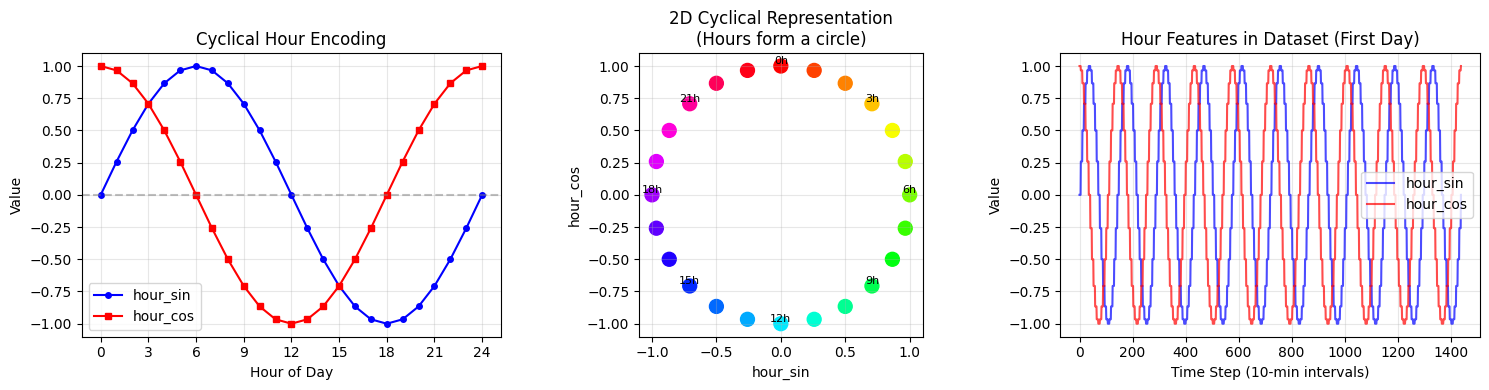


✓ Hour encoding visualization complete
Note: Hour 0 and Hour 23 are adjacent in the 2D (sin,cos) space, preserving cyclical nature.


In [155]:
# Visualize the cyclical hour-of-day encoding

# Create sample hours for visualization
hours = np.arange(0, 25)  # 0-24 to show wrap-around
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sin and Cos over 24 hours
axes[0].plot(hours, hour_sin, 'b-o', label='hour_sin', markersize=4)
axes[0].plot(hours, hour_cos, 'r-s', label='hour_cos', markersize=4)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Value')
axes[0].set_title('Cyclical Hour Encoding')
axes[0].legend()
axes[0].set_xticks(range(0, 25, 3))
axes[0].grid(True, alpha=0.3)

# Plot 2: 2D representation (sin vs cos) - shows cyclical nature
axes[1].scatter(hour_sin[:24], hour_cos[:24], c=hours[:24], cmap='hsv', s=100)
for h in range(0, 24, 3):
    axes[1].annotate(f'{h}h', (hour_sin[h], hour_cos[h]), fontsize=8, ha='center', va='bottom')
axes[1].set_xlabel('hour_sin')
axes[1].set_ylabel('hour_cos')
axes[1].set_title('2D Cyclical Representation\n(Hours form a circle)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Plot 3: Sample from actual data (if available)
if 'df_enhanced' in dir() and df_enhanced is not None:
    sample = df_enhanced[['hour_sin', 'hour_cos']].iloc[:1440]  # ~1 day at 10-min intervals
    axes[2].plot(sample['hour_sin'].values, 'b-', label='hour_sin', alpha=0.7)
    axes[2].plot(sample['hour_cos'].values, 'r-', label='hour_cos', alpha=0.7)
    axes[2].set_xlabel('Time Step (10-min intervals)')
    axes[2].set_ylabel('Value')
    axes[2].set_title('Hour Features in Dataset (First Day)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Load dataset to see\nactual hour features', 
                 ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Hour Features in Dataset')

plt.tight_layout()
plt.show()

print("\n✓ Hour encoding visualization complete")
print("Note: Hour 0 and Hour 23 are adjacent in the 2D (sin,cos) space, preserving cyclical nature.")

✓ Dataset found at: /home/hkrishnamoorthy/projects/Capstone/CSPatchTST/datasets/weather/weather_with_hour.csv

Dataset shape: (52696, 24)

First few rows:
                  date  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
1  2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2  2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
3  2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
4  2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wd (deg)  \
0          6.43          5.54          0.89       3.42  ...     224.3   
1          6.45          5.49          0.95       3.39  ...     206.8   
2          6.44          5.48          0.96       3.39  ...     197.1   
3          6.27          5.41          0.86       3.35  ...     206.4   
4          6.26  

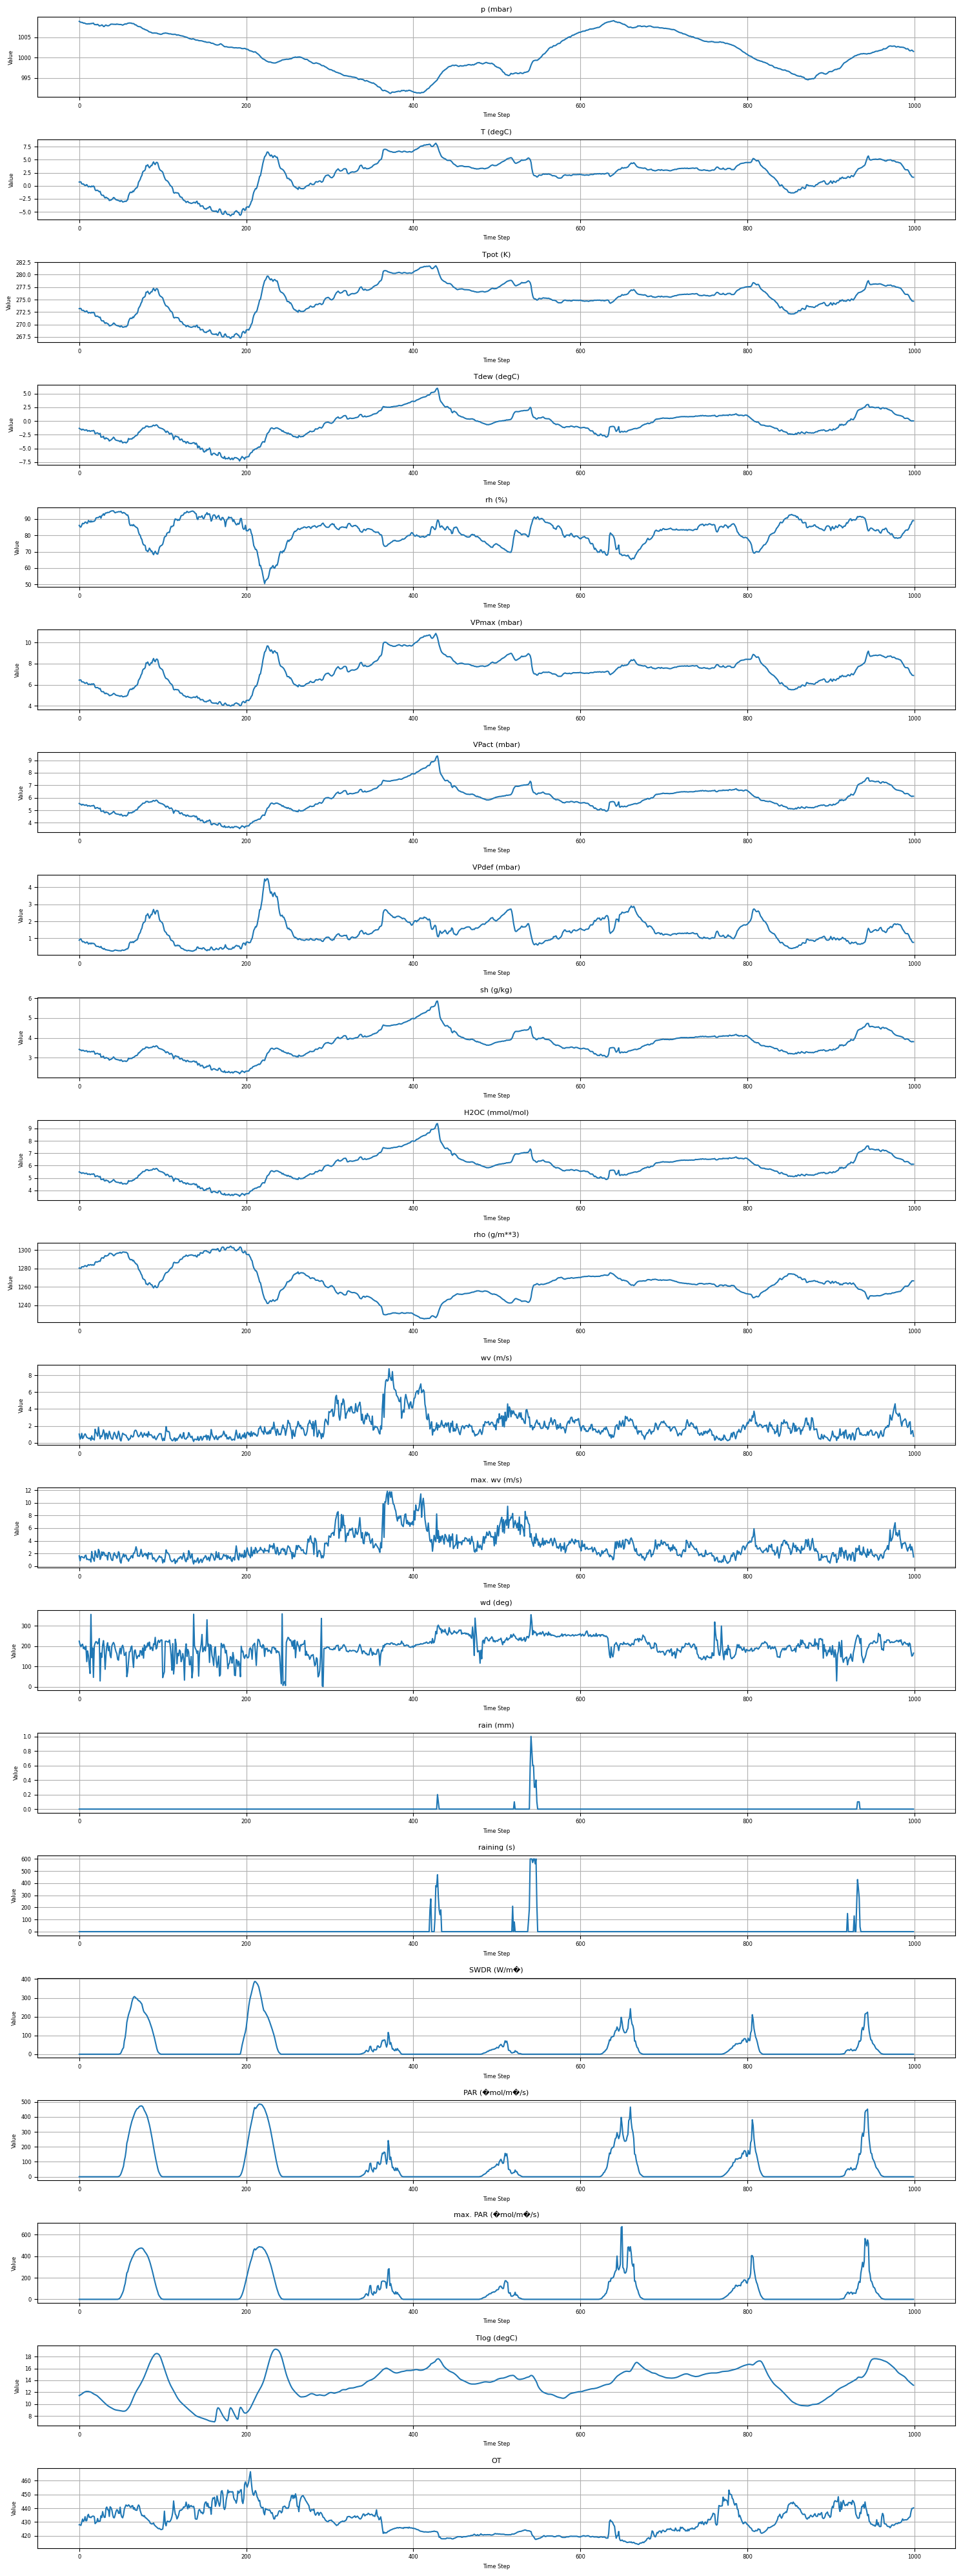

In [156]:
# Check if dataset exists
dataset_path = os.path.join(args.root_path, args.data_path)
if os.path.exists(dataset_path):
    print(f"✓ Dataset found at: {dataset_path}")
    
    # Load and explore the dataset
    df = pd.read_csv(dataset_path)
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData types:")
    print(df.dtypes)
    
    # Visualize a sample of the data
    fig, axes = plt.subplots(21, 1, figsize=(15, 40)) # Increased figure size
    for i, col in enumerate(df.columns[1:22]):
        axes[i].plot(df[col][:1000])
        axes[i].set_title(f'{col}', fontsize=8)
        axes[i].set_xlabel('Time Step', fontsize=6)
        axes[i].set_ylabel('Value', fontsize=6)
        axes[i].tick_params(axis='both', which='major', labelsize=6) # Set tick label size
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"✗ Dataset not found at: {dataset_path}")
    print(f"\nPlease download the dataset from:")
    print(f"https://drive.google.com/drive/folders/1ZOYpTUa82_jCcxIdTmyr0LXQfvaM9vIy")
    print(f"\nAnd place it in the {args.root_path} folder")

In [157]:
train_data, train_loader = data_provider(args, flag='train')
val_data, val_loader = data_provider(args, flag='val')
test_data, test_loader = data_provider(args, flag='test')

print(f"\nData Loaders Created:")
print(f"  Training samples: {len(train_data)}")
print(f"  Validation samples: {len(val_data)}")
print(f"  Test samples: {len(test_data)}")

# Inspect a batch
for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
    print(f"\nBatch shapes:")
    print(f"  Input (batch_x): {batch_x.shape}")
    print(f"  Target (batch_y): {batch_y.shape}")
    print(f"  Input time features (batch_x_mark): {batch_x_mark.shape}")
    print(f"  Target time features (batch_y_mark): {batch_y_mark.shape}")
    break

train 36040
val 4935
test 10204

Data Loaders Created:
  Training samples: 36040
  Validation samples: 4935
  Test samples: 10204

Batch shapes:
  Input (batch_x): torch.Size([32, 512, 23])
  Target (batch_y): torch.Size([32, 384, 23])
  Input time features (batch_x_mark): torch.Size([32, 512, 5])
  Target time features (batch_y_mark): torch.Size([32, 384, 5])


## 4. Physics-Integrated Model Definition <a id='model'></a>

This model has a key design difference from the previous version:

**Hour features are INTEGRATED into physics groups** - The same hour_sin/hour_cos channels are fed to multiple encoders (thermodynamics, moisture, precipitation), allowing each to learn the hour-physics correlation at its appropriate time scale.

**Output is weather-only** - We predict 21 weather channels, not the hour features (which are deterministic from timestamps).

In [158]:
# ============================================================================
# Multi-Scale Ensemble with Per-Channel Learned Weights
# ============================================================================

from typing import List, Dict, Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F

class LearnableMultiScaleEncoder(nn.Module):
    def __init__(self, config, group_name: str, patch_candidates: List[int]):
        super().__init__()
        self.group_name = group_name
        self.patch_candidates = patch_candidates

        group_indices = config.channel_groups[group_name]['indices']
        hour_idx = set(config.hour_feature_indices)

        self.n_in = len(group_indices)
        self.n_out = len([i for i in group_indices if i not in hour_idx])

        self.encoders = nn.ModuleDict()
        for patch_len in patch_candidates:
            stride = max(patch_len // 2, 1)
            self.encoders[f'patch_{patch_len}'] = PerChannelEncoder(
                n_input_channels=self.n_in,
                n_output_channels=self.n_out,
                context_window=config.seq_len,
                target_window=config.pred_len,
                patch_len=patch_len,
                stride=stride,
                n_layers=config.e_layers,
                d_model=config.d_model,
                n_heads=config.n_heads,
                d_ff=config.d_ff,
                dropout=config.dropout,
                head_dropout=config.head_dropout,
                padding_patch=config.padding_patch
            )

        # logits is a better name than weights (softmax turns logits -> weights)
        self.mixing_logits = nn.Parameter(torch.zeros(self.n_out, len(patch_candidates)))

    def forward(self, x: torch.Tensor, output_mask: List[bool]):
        # weights: [n_out, K]
        weights = F.softmax(self.mixing_logits, dim=-1)

        outputs = []
        for patch_len in self.patch_candidates:
            y = self.encoders[f'patch_{patch_len}'](x, output_mask)  # expected [B, n_out, pred_len]
            # Safety check (remove later if you want)
            assert y.dim() == 3 and y.shape[1] == self.n_out, \
                f"Expected [B, {self.n_out}, pred_len], got {tuple(y.shape)}"
            outputs.append(y)

        # [K, B, n_out, pred_len]
        stacked = torch.stack(outputs, dim=0)

        # [K, 1, n_out, 1]
        w = weights.transpose(0, 1).unsqueeze(1).unsqueeze(-1)

        # [B, n_out, pred_len]
        return (stacked * w).sum(dim=0)

    def get_weight_distribution(self):
        weights = F.softmax(self.mixing_logits, dim=-1).detach().cpu()
        return {
            ch: {pl: float(weights[ch, i]) for i, pl in enumerate(self.patch_candidates)}
            for ch in range(self.n_out)
        }

    def get_dominant_patch_length(self):
        weights = F.softmax(self.mixing_logits, dim=-1)
        idx = torch.argmax(weights, dim=-1)
        return {ch: self.patch_candidates[int(idx[ch])] for ch in range(self.n_out)}

    def get_average_weight_distribution(self):
        weights = F.softmax(self.mixing_logits, dim=-1).detach().cpu()
        avg = weights.mean(dim=0)
        return {pl: float(avg[i]) for i, pl in enumerate(self.patch_candidates)}



# ============================================================================
# Helper: Modify your PhysicsIntegratedPatchTST to use learnable encoders
# ============================================================================

def create_learnable_model(base_config):
    """
    Create version of your model with per-channel learnable patch lengths.
    Includes ALL features from PhysicsIntegratedPatchTST:
    - Cross-group attention or MLP Mixer fusion
    - RevIN normalization
    - Learnable cross_group_weight
    - Per-channel patch length mixing (NEW!)
    
    Usage:
        model = create_learnable_model(args)
        # Train normally - patch length weights are learned automatically!
        
        # After training:
        for group_name, encoder in model.encoders.items():
            weights = encoder.get_weight_distribution()
            dominant = encoder.get_dominant_patch_length()
            print(f"{group_name}:")
            print(f"  Dominant per channel: {dominant}")
            print(f"  Avg distribution: {encoder.get_average_weight_distribution()}")
    """
    
    # ⚡ OPTIMIZED: Reduced to 2 candidates per group for 2x speedup
    # Original had 3-4 candidates → 18 total encoders
    # Now: 2 candidates → 10 total encoders (45% fewer!)
    patch_candidates = {
        'atmospheric_dynamics': [12, 24, 48],   # Short vs medium synoptic
        'temperature': [24, 36],            # Diurnal vs longer  
        'radiation': [12, 24],              # Fast vs moderate changes
        'moisture': [24, 48],               # Medium vs long
        'precipitation': [8, 16]            # Short vs medium spiky
    }
    
    # If you want even faster (experimental):
    # Reduce to just 1 candidate = original fixed-length model (no learning)
    # patch_candidates = {'atmospheric_dynamics': [36], 'temperature': [24], ...}
    
    # Create model with learnable multi-scale encoders
    class LearnablePatchLengthModel(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.config = config
            self.seq_len = config.seq_len
            self.pred_len = config.pred_len
            self.enc_in = config.enc_in
            self.c_out = config.c_out
            self.channel_groups = config.channel_groups
            self.hour_indices = set(config.hour_feature_indices)
            self.cga_flag = getattr(config, 'cga_flag', True)
            
            # RevIN
            self.revin = config.revin
            if self.revin:
                self.revin_layer = RevIN(config.enc_in, affine=config.affine, 
                                          subtract_last=config.subtract_last)
            
            # Create learnable encoder for each group
            self.encoders = nn.ModuleDict()
            self.group_info = {}
            
            for group_name, group_cfg in config.channel_groups.items():
                indices = group_cfg['indices']
                weather_indices = [i for i in indices if i not in self.hour_indices]
                hour_indices = [i for i in indices if i in self.hour_indices]
                output_mask = [i not in self.hour_indices for i in indices]
                
                self.group_info[group_name] = {
                    'all_indices': indices,
                    'weather_indices': weather_indices,
                    'hour_indices': hour_indices,
                    'output_mask': output_mask,
                    'n_input': len(indices),
                    'n_output': len(weather_indices)
                }
                
                # Use learnable multi-scale encoder
                candidates = patch_candidates.get(group_name, [12, 24])
                self.encoders[group_name] = LearnableMultiScaleEncoder(
                    config, group_name, candidates
                )
            
            # Cross-group attention or MLP Mixer (same as original)
            if self.cga_flag:
                self.cross_group_attn = CrossGroupAttention(
                    n_channels=config.c_out,
                    d_model=config.d_model // 2,
                    n_heads=4,
                    dropout=config.dropout
                )
                self.cross_group_weight = nn.Parameter(torch.tensor(0.3))
            else:
                self.fusion = MLPMixerFusion(
                    pred_len=config.pred_len,
                    n_channels=config.c_out,
                    ch_hidden_mult=2,
                    t_hidden_mult=2,
                    dropout=config.dropout
                )
                self.cross_group_weight = nn.Parameter(torch.tensor(0.3))
        
        def forward(self, x):
            bs = x.shape[0]
            x = x.permute(0, 2, 1)
            
            if self.revin:
                x = x.permute(0, 2, 1)
                x = self.revin_layer(x, 'norm')
                x = x.permute(0, 2, 1)
            
            all_outputs = torch.zeros(bs, self.c_out, self.pred_len, device=x.device)
            
            for group_name, encoder in self.encoders.items():
                info = self.group_info[group_name]
                group_x = x[:, info['all_indices'], :]
                group_out = encoder(group_x, info['output_mask'])
                
                for i, ch_idx in enumerate(info['weather_indices']):
                    all_outputs[:, ch_idx, :] = group_out[:, i, :]
            
            output = all_outputs.permute(0, 2, 1)
            
            # Cross-group attention
            if self.cga_flag:
                cross_output = self.cross_group_attn(output)
            else:
                cross_output = self.fusion(output)
            
            alpha = torch.sigmoid(self.cross_group_weight)
            output = (1 - alpha) * output + alpha * cross_output
            
            if self.revin:
                temp_output = torch.zeros(bs, self.pred_len, self.enc_in, device=x.device)
                temp_output[:, :, :self.c_out] = output
                temp_output = self.revin_layer(temp_output, 'denorm')
                output = temp_output[:, :, :self.c_out]
            
            return output
    
    return LearnablePatchLengthModel(base_config)


print("✓ LearnableMultiScaleEncoder defined")
print("  Optimization: Reduced to 2 patch candidates per group")
print("  Total encoders: 10 (down from 18 original)")
print("  Expected speedup: ~1.8x faster training")

✓ LearnableMultiScaleEncoder defined
  Optimization: Reduced to 2 patch candidates per group
  Total encoders: 10 (down from 18 original)
  Expected speedup: ~1.8x faster training


In [ ]:
# Physics-Integrated PatchTST Model with Cross-Group Attention
# Hour features are integrated INTO physics groups, not kept separate
# Cross-group attention enables learning inter-variable dependencies

class PerChannelEncoder(nn.Module):
    """Encoder for a group of channels with specific patch length.
    
    For groups with hour features integrated, the encoder learns
    the correlation between hour-of-day and physics variables directly.
    
    Uses a deeper 3-layer feedforward network for learning complex patterns.
    """
    def __init__(self, n_input_channels, n_output_channels, context_window, target_window, 
                 patch_len, stride, n_layers=3, d_model=128, n_heads=8, d_ff=256, 
                 ffn_layers=3, dropout=0.2, head_dropout=0.0, padding_patch='end'):
        super().__init__()
        
        self.n_input_channels = n_input_channels   # Includes hour features if integrated
        self.n_output_channels = n_output_channels  # Only weather channels
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.d_model = d_model
        
        # Calculate patch count
        patch_num = int((context_window - patch_len) / stride + 1)
        if padding_patch == 'end':
            self.padding_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1
        self.patch_num = patch_num
        
        # Patch embedding (project patch_len → d_model)
        self.W_P = nn.Linear(patch_len, d_model)
        
        # Positional encoding (learnable)
        self.W_pos = nn.Parameter(torch.zeros(1, patch_num, d_model))
        nn.init.normal_(self.W_pos, std=0.02)
        
        # Deeper Feedforward Network (3 layers instead of 2)
        # This enables learning more complex non-linear patterns
        self.deep_ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_ff),  # Extra hidden layer
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.ffn_norm = nn.LayerNorm(d_model)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Per-channel prediction heads (only for OUTPUT channels, not hour features)
        self.head_nf = d_model * patch_num
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Flatten(start_dim=-2),
                nn.Linear(self.head_nf, target_window),
                nn.Dropout(head_dropout)
            ) for _ in range(n_output_channels)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, output_channel_mask): # Harish Modified this to parallelize the heads and avoid for loop
        """
        Args:
            x: [bs, n_input_channels, seq_len]
            output_channel_mask: list[bool] length n_input_channels
                True for channels to output (weather), False for input-only (hour)
        Returns:
            output: [bs, n_output_channels, target_window]
        """
        bs, n_ch, seq_len = x.shape

        # Padding if needed
        if self.padding_patch == 'end':
            x = self.padding_layer(x)

        # Patchify: [bs, n_ch, patch_num, patch_len]
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)

        # ---------------------------------------------------------
        # Vectorize across channels: treat each channel as a "batch item"
        # ---------------------------------------------------------
        # [bs*n_ch, patch_num, patch_len]
        x = x.reshape(bs * n_ch, self.patch_num, self.patch_len)

        # Patch embedding: [bs*n_ch, patch_num, d_model]
        x = self.W_P(x)

        # Positional encoding + dropout (broadcast over bs*n_ch)
        x = self.dropout(x + self.W_pos)

        # Deep FFN residual
        x = x + self.deep_ffn(self.ffn_norm(x))

        # Transformer encoder ONCE: [bs*n_ch, patch_num, d_model]
        z = self.encoder(x)

        # Reshape back: [bs, n_ch, patch_num, d_model]
        z = z.reshape(bs, n_ch, self.patch_num, self.d_model)

        # ---------------------------------------------------------
        # Select only weather channels (mask True), ignore hour channels
        # ---------------------------------------------------------
        mask = torch.as_tensor(output_channel_mask, device=z.device, dtype=torch.bool)
        z_weather = z[:, mask, :, :]   # [bs, n_out, patch_num, d_model]

        # ---------------------------------------------------------
        # Apply per-output heads (small loop; cheap compared to Transformer loop)
        # ---------------------------------------------------------
        outs = []
        for i in range(z_weather.shape[1]):
            outs.append(self.heads[i](z_weather[:, i, :, :]))  # [bs, target_window]

        output = torch.stack(outs, dim=1)  # [bs, n_out, target_window]
        return output



class CrossGroupAttention(nn.Module):
    """
    Cross-Group Attention Layer to learn inter-variable dependencies.
    
    This allows the model to learn physical couplings between groups:
    - Temperature -> Humidity (warm air holds more moisture)
    - Humidity -> Precipitation (saturation triggers rain)
    - Pressure gradients -> Wind
    - Temperature -> Convection -> Rain
    """
    def __init__(self, n_channels, d_model, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_channels = n_channels
        self.d_model = d_model
    
        # Project each channel's prediction to d_model
        self.channel_proj = nn.Linear(1, d_model)
        # Layer normalization for input
        self.norm1 = nn.LayerNorm(d_model)
        
        # Cross-channel attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Deeper Feed-forward network for refinement (3 layers instead of 2)
        # Enables learning more complex cross-channel dependencies
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model * 2),  # Extra hidden layer
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(d_model)
        
        # Project back to prediction
        self.output_proj = nn.Linear(d_model, 1)
        
    def forward(self, x):
        """
        Args:
            x: [bs, pred_len, n_channels] - independent group predictions
        Returns:
            x: [bs, pred_len, n_channels] - cross-group refined predictions
        """
        bs, pred_len, n_ch = x.shape
        
        # Reshape: [bs * pred_len, n_channels, 1]
        x_reshaped = x.reshape(bs * pred_len, n_ch, 1)
        
        # Project to d_model: [bs * pred_len, n_channels, d_model]
        x_proj = self.channel_proj(x_reshaped)
        
        # Pre-norm for attention
        x_norm = self.norm1(x_proj)
        
        # Cross-channel attention (channels attend to each other)
        # This learns: "when predicting rain, look at temperature and humidity"
        x_attn, _ = self.cross_attn(x_norm, x_norm, x_norm)
        x_proj = x_proj + x_attn  # Residual connection
        # Feed-forward refinement
        # Feed-forward refinement
        x_ffn = self.ffn(self.norm2(x_proj))
        x_proj = x_proj + x_ffn  # Residual connection
        
        # Project back: [bs * pred_len, n_channels, 1]
        x_out = self.output_proj(x_proj)
        
        # Reshape: [bs, pred_len, n_channels]
        x_out = x_out.reshape(bs, pred_len, n_ch)
        
        return x_out


class MLPMixerFusion(nn.Module):
    """
    Mix across channels and across time (pred_len).
    Input/Output: [bs, pred_len, n_channels]
    """
    def __init__(self, pred_len, n_channels, ch_hidden_mult=2, t_hidden_mult=2, dropout=0.1):
        super().__init__()
        ch_hidden = int(n_channels * ch_hidden_mult)
        t_hidden = int(pred_len * t_hidden_mult)

        self.norm_ch = nn.LayerNorm(n_channels)
        self.mlp_ch = nn.Sequential(
            nn.Linear(n_channels, ch_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ch_hidden, n_channels),
            nn.Dropout(dropout),
        )
        self.norm_t = nn.LayerNorm(pred_len)
        self.mlp_t = nn.Sequential(
            nn.Linear(pred_len, t_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(t_hidden, pred_len),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Channel mix: operate on last dim
        x = x + self.mlp_ch(self.norm_ch(x))

        # Time mix: transpose to mix along pred_len dimension
        xt = x.transpose(1, 2)              # [bs, n_channels, pred_len]
        xt = xt + self.mlp_t(self.norm_t(xt))
        x = xt.transpose(1, 2)              # [bs, pred_len, n_channels]
        return x


class PhysicsIntegratedPatchTST(nn.Module):
    """
    Physics-Integrated PatchTST with hour features and Cross-Group Attention.
    
    Architecture:
    1. Group-specific encoders (physics-appropriate patch lengths)
    2. Cross-group attention (learns inter-variable dependencies)
    3. Output predictions
    
    Key Features:
    - Hour features (hour_sin, hour_cos) are fed to multiple physics encoders
    - Each encoder learns hour-physics correlations at its appropriate time scale
    - Cross-group attention enables learning couplings between physics groups
    - Only weather channels are predicted (hour features are input-only)
    """
    def __init__(self, configs): 
        super().__init__()
        
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.enc_in = configs.enc_in  # 23 (21 weather + 2 hour)
        self.c_out = configs.c_out    # 21 (weather only)
        self.channel_groups = configs.channel_groups
        self.patch_configs = configs.patch_configs
        self.hour_indices = set(configs.hour_feature_indices)  # {21, 22}
        self.cga_flag = getattr(configs, 'cga_flag', True)  # Use config flag if provided
        
        # RevIN for normalization (all input channels)
        self.revin = configs.revin
        if self.revin:
            self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, 
                                      subtract_last=configs.subtract_last)
        # Create encoder for each channel group
        # Create encoder for each channel group
        self.encoders = nn.ModuleDict()
        self.group_info = {}
        
        for group_name, group_info in self.channel_groups.items():
            indices = group_info['indices']
            patch_config = self.patch_configs[group_name]
            # Separate weather channels from hour channels in this group
            weather_indices = [i for i in indices if i not in self.hour_indices]
            hour_indices_in_group = [i for i in indices if i in self.hour_indices]
            
            # Create mask: True for weather channels, False for hour channels
            output_mask = [i not in self.hour_indices for i in indices]
            
            self.group_info[group_name] = {
                'all_indices': indices,
                'weather_indices': weather_indices,
                'hour_indices': hour_indices_in_group,
                'output_mask': output_mask,
                'n_input': len(indices),
                'n_output': len(weather_indices)
            }
            
            self.encoders[group_name] = PerChannelEncoder(
                n_input_channels=len(indices),
                n_output_channels=len(weather_indices),  # Only predict weather
                context_window=configs.seq_len,
                target_window=configs.pred_len,
                patch_len=patch_config['patch_len'],
                stride=patch_config['stride'],
                n_layers=configs.e_layers,
                d_model=configs.d_model,
                n_heads=configs.n_heads,
                d_ff=configs.d_ff,
                dropout=configs.dropout,
                head_dropout=configs.head_dropout,
                padding_patch=configs.padding_patch
            )
        
        self.group_weights = {name: cfg['weight'] for name, cfg in self.patch_configs.items()}
        
        if self.cga_flag:
            # Two-stage cross-group attention (NEW!)
            # Stage 1: Learn direct inter-variable dependencies
            # Stage 2: Refine with deeper cross-channel interactions
            self.cross_group_attn_1 = CrossGroupAttention(
                n_channels=configs.c_out,  # 21 weather channels
                d_model=configs.d_model // 2,  # Smaller for efficiency (64 if d_model=128)
                n_heads=4,
                dropout=configs.dropout
            )
            # Second stage cross-group attention
            self.cross_group_attn_2 = CrossGroupAttention(
                n_channels=configs.c_out,
                d_model=configs.d_model // 2,
                n_heads=4,
                dropout=configs.dropout
            )
            # Learnable mixing weights for each stage
            # Initialized to 0.3 so each stage starts with moderate influence
            self.cross_group_weight_1 = nn.Parameter(torch.tensor(0.3))
            self.cross_group_weight_2 = nn.Parameter(torch.tensor(0.3))
        else:
            self.fusion = MLPMixerFusion(
                pred_len=configs.pred_len,
                n_channels=configs.c_out,
                ch_hidden_mult=2,
                t_hidden_mult=2,
                dropout=configs.dropout
            )
            self.cross_group_weight = nn.Parameter(torch.tensor(0.3))

    def forward(self, x):
        """
        Args:
            x: [bs, seq_len, 23] - 21 weather + 2 hour features
        Returns:
            output: [bs, pred_len, 21] - only weather predictions
        """
        bs = x.shape[0]
        
        # Permute to [bs, enc_in, seq_len]
        x = x.permute(0, 2, 1)
        
        # Apply RevIN normalization
        if self.revin:
            x = x.permute(0, 2, 1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0, 2, 1)
        
        # ========================================
        # Step 1: Group-independent encoding
        # ========================================
        # Each group processes its channels with physics-appropriate patch length
        all_outputs = torch.zeros(bs, self.c_out, self.pred_len, device=x.device)
        
        for group_name, encoder in self.encoders.items():
            info = self.group_info[group_name]
            
            # Extract all channels for this group (including hour features)
            group_x = x[:, info['all_indices'], :]
            
            # Encode - returns only weather channel outputs
            group_out = encoder(group_x, info['output_mask'])
            
            # Place weather outputs in correct positions
            for i, ch_idx in enumerate(info['weather_indices']):
                all_outputs[:, ch_idx, :] = group_out[:, i, :]
        # Step 2: Two-stage cross-group refinement (NEW!)
        # Permute to [bs, pred_len, c_out]
        # Channels attend to each other in two stages for deeper fusion
        
            # Stage 1: First cross-group attention
            cross_output_1 = self.cross_group_attn_1(output)
            alpha_1 = torch.sigmoid(self.cross_group_weight_1)
            output = (1 - alpha_1) * output + alpha_1 * cross_output_1
            
            # Stage 2: Second cross-group attention on refined features
            cross_output_2 = self.cross_group_attn_2(output)
            alpha_2 = torch.sigmoid(self.cross_group_weight_2)
            output = (1 - alpha_2) * output + alpha_2 * cross_output_2
        else:
            cross_output = self.fusion(output)
            alpha = torch.sigmoid(self.cross_group_weight)
            output = (1 - alpha) * output + alpha * cross_output
        
        # ========================================
        # Step 3: RevIN denormalization
        # ========================================
        if self.revin:
            # Need to handle the dimension mismatch for denorm
            # Create a temporary tensor with all channels for denorm
            temp_output = torch.zeros(bs, self.pred_len, self.enc_in, device=x.device)
            temp_output[:, :, :self.c_out] = output
            temp_output = self.revin_layer(temp_output, 'denorm')
            output = temp_output[:, :, :self.c_out]
        
        return output

# Create the Physics-Integrated model with Cross-Group Attention
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#model = PhysicsIntegratedPatchTST(args).float() # Harish Change to use learnable patches
model = create_learnable_model(args).float()
model = model.to(device)

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=1e-4)

# Learning rate scheduler with warmup
def get_scheduler(optimizer, num_warmup_steps=1000, num_training_steps=10000):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.1, 0.5 * (1 + np.cos(np.pi * (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps))))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_scheduler(optimizer, num_warmup_steps=500, num_training_steps=len(train_loader) * args.train_epochs)

print(f"\n✓ Physics-Integrated PatchTST with Cross-Group Attention Created!")
print(f"\nModel Configuration:")
print(f"  Input channels: {args.enc_in} (21 weather + 2 hour)")
print(f"  Output channels: {args.c_out} (21 weather only)")
print(f"  Cross-group attention: ENABLED (learns inter-variable dependencies)")
print(f"  Hour features integrated into: temperature, radiation, moisture, precipitation")

print(f"\nGroup Details:")
print(f"\nTwo-Stage Cross-Group Attention Info:")
print(f"  Stage 1: Learn direct inter-variable dependencies")
print(f"  Stage 2: Refine with deeper cross-channel interactions")
print(f"  Enables learning of physical couplings:")
print(f"    - Temperature -> Humidity (warm air holds more moisture)")
print(f"    - Humidity -> Precipitation (saturation triggers rain)")
print(f"    - Pressure gradients -> Wind")
print(f"    - Solar radiation -> Temperature -> Convection")
if hasattr(model, 'cross_group_weight_1'):
    print(f"  Initial mixing weight (stage 1): {model.cross_group_weight_1.item():.2f}")
    print(f"  Initial mixing weight (stage 2): {model.cross_group_weight_2.item():.2f}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
if model.cga_flag:

    cross_attn_params = sum(p.numel() for p in model.cross_group_attn_1.parameters()) + sum(p.numel() for p in model.cross_group_attn_2.parameters())
cross_attn_params = sum(p.numel() for p in model.cross_group_attn.parameters()) if model.cga_flag else sum(p.numel() for p in model.fusion.parameters())
cross_attn_params = sum(p.numel() for p in model.cross_group_attn.parameters()) if model.cga_flag else sum(p.numel() for p in model.fusion.parameters())

else:
print(f"\nParameter Count:")
print(f"\nParameter Count:")print(f"  Cross-group attention: {cross_attn_params:,} ({100*cross_attn_params/total_params:.1f}%)")

    cross_attn_params = sum(p.numel() for p in model.fusion.parameters())
print(f"  Total: {total_params:,}")
print(f"  Total: {total_params:,}")

print(f"\nParameter Count:")
print(f"  Cross-group attention: {cross_attn_params:,} ({100*cross_attn_params/total_params:.1f}%)")
print(f"  Cross-group attention: {cross_attn_params:,} ({100*cross_attn_params/total_params:.1f}%)")
print(f"  Total: {total_params:,}")

Using device: cuda:0

✓ Physics-Integrated PatchTST with Cross-Group Attention Created!

Model Configuration:
  Input channels: 23 (21 weather + 2 hour)
  Output channels: 21 (21 weather only)
  Cross-group attention: ENABLED (learns inter-variable dependencies)
  Hour features integrated into: temperature, radiation, moisture, precipitation

Group Details:
  atmospheric_dynamics:
    Input channels: 4 (weather: 4, hour: 0)
    Patch length: 48 steps
  temperature:
    Input channels: 8 (weather: 6, hour: 2)
    Patch length: 36 steps
  radiation:
    Input channels: 4 (weather: 2, hour: 2)
    Patch length: 12 steps
  moisture:
    Input channels: 9 (weather: 7, hour: 2)
    Patch length: 36 steps
  precipitation:
    Input channels: 4 (weather: 2, hour: 2)
    Patch length: 8 steps

Cross-Group Attention Info:
  Enables learning of physical couplings:
    - Temperature -> Humidity (warm air holds more moisture)
    - Humidity -> Precipitation (saturation triggers rain)
    - Pressure

In [160]:
# Detailed model analysis (updated for Per-Channel LearnableMultiScaleEncoder)
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"\n{'='*80}")
print(f"MODEL PARAMETERS (Per-Channel Learnable Multi-Scale Architecture)")
print(f"{'='*80}")
print(f"  Total parameters: {total:,}")
print(f"  Trainable parameters: {trainable:,}")
print(f"  Model size: ~{total * 4 / 1024 / 1024:.2f} MB (fp32)")

# Per-encoder breakdown (handles per-channel LearnableMultiScaleEncoder)
print(f"\n{'='*80}")
print(f"PER-GROUP ENCODER DETAILS (Per-Channel Multi-Scale)")
print(f"{'='*80}")

for group_name, encoder in model.encoders.items():
    group_params = sum(p.numel() for p in encoder.parameters())
    group_info = model.group_info[group_name]
    
    print(f"\n{group_name.upper()} Encoder:")
    print(f"  Channels: {group_info['n_input']} input → {group_info['n_output']} output")
    
    # Check if it's LearnableMultiScaleEncoder or regular PerChannelEncoder
    if hasattr(encoder, 'patch_candidates'):
        # Per-Channel LearnableMultiScaleEncoder
        print(f"  Patch candidates: {encoder.patch_candidates}")
        
        # Get per-channel learned weights
        weights_per_channel = encoder.get_weight_distribution()
        dominant_per_channel = encoder.get_dominant_patch_length()
        avg_weights = encoder.get_average_weight_distribution()
        
        # Show average distribution across all channels
        print(f"  Average weight distribution (across all channels):")
        for patch_len, weight in sorted(avg_weights.items(), key=lambda x: x[1], reverse=True):
            bar = "█" * int(weight * 30)
            print(f"    {patch_len:3d} steps ({patch_len*10:3d} min): {weight:6.1%}  {bar}")
        
        # Show dominant patch length per channel
        print(f"  Dominant patch lengths per channel:")
        for ch_idx, patch_len in dominant_per_channel.items():
            # Try to get channel name from group_info
            channel_names = model.config.channel_groups[group_name].get('names', [])
            if ch_idx < len(channel_names):
                ch_name = channel_names[ch_idx]
                print(f"    Channel {ch_idx} ({ch_name}): {patch_len} steps ({patch_len*10} min)")
            else:
                print(f"    Channel {ch_idx}: {patch_len} steps ({patch_len*10} min)")
        
        # Show sub-encoder details
        print(f"  Sub-encoders (one per patch length candidate):")
        for patch_len in encoder.patch_candidates:
            sub_enc = encoder.encoders[f'patch_{patch_len}']
            sub_params = sum(p.numel() for p in sub_enc.parameters())
            print(f"    patch_{patch_len}: {sub_params:,} params, {sub_enc.patch_num} patches/channel")
    else:
        # Regular PerChannelEncoder
        if hasattr(args, 'patch_configs') and group_name in args.patch_configs:
            patch_cfg = args.patch_configs[group_name]
            print(f"  Patch length: {patch_cfg['patch_len']} steps ({patch_cfg['patch_len']*10} min)")
            print(f"  Stride: {patch_cfg['stride']} steps ({patch_cfg['stride']*10} min)")
        if hasattr(encoder, 'patch_num'):
            print(f"  Patches per channel: {encoder.patch_num}")
    
    print(f"  Total parameters: {group_params:,}")

# Show mixing weights for learnable encoders
total_mixing_params = sum(enc.mixing_weights.numel() for enc in model.encoders.values() 
                           if hasattr(enc, 'mixing_weights'))
if total_mixing_params > 0:
    print(f"\n{'='*80}")
    print(f"LEARNABLE PATCH LENGTH MIXING (PER-CHANNEL)")
    print(f"{'='*80}")
    print(f"  Total mixing weight parameters: {total_mixing_params}")
    print(f"  Each output channel learns its own patch length preferences")
    print(f"  E.g., wind speed can prefer short patches while pressure prefers long")

print(f"\n{'='*80}")


MODEL PARAMETERS (Per-Channel Learnable Multi-Scale Architecture)
  Total parameters: 95,932,432
  Trainable parameters: 95,932,432
  Model size: ~365.95 MB (fp32)

PER-GROUP ENCODER DETAILS (Per-Channel Multi-Scale)

ATMOSPHERIC_DYNAMICS Encoder:
  Channels: 4 input → 4 output
  Patch candidates: [12, 24, 48]
  Average weight distribution (across all channels):
     12 steps (120 min):  33.3%  ██████████
     24 steps (240 min):  33.3%  ██████████
     48 steps (480 min):  33.3%  ██████████
  Dominant patch lengths per channel:
    Channel 0 (p (mbar)): 12 steps (120 min)
    Channel 1 (wv (m/s)): 12 steps (120 min)
    Channel 2 (max. wv (m/s)): 12 steps (120 min)
    Channel 3 (wd (deg)): 12 steps (120 min)
  Sub-encoders (one per patch length candidate):
    patch_12: 15,166,016 params, 85 patches/channel
    patch_24: 7,764,672 params, 42 patches/channel
    patch_48: 4,152,384 params, 21 patches/channel
  Total parameters: 27,083,084

TEMPERATURE Encoder:
  Channels: 8 input → 6

In [161]:
# Print complete model architecture
print("=" * 80)
print("📐 FULL MODEL ARCHITECTURE (Learnable Multi-Scale)")
print("=" * 80)
print(model)
print("=" * 80)

# Detailed architecture breakdown
print("\n" + "=" * 80)
print("🔍 ARCHITECTURE BREAKDOWN")
print("=" * 80)

print("\n1️⃣ LEARNABLE MULTI-SCALE ENCODERS:")
print("   Each physics group has multiple patch length candidates")
print("   Model learns optimal mixing weights during training")
print("   └── Candidates trained simultaneously")
print("       ├── Each candidate: independent PerChannelEncoder")
print("       └── Learnable weights: softmax-normalized mixing")

print("\n2️⃣ PER-CHANNEL ENCODER (within each candidate):")
print("   Deep FFN (3 layers):")
print("   ├── Linear(d_model → d_ff)   [128 → 256]")
print("   ├── GELU + Dropout")
print("   ├── Linear(d_ff → d_ff)      [256 → 256] ← Extra layer")
print("   ├── GELU + Dropout")
print("   └── Linear(d_ff → d_model)   [256 → 128]")
print("   Transformer Encoder (3 layers):")
print("   └── Multi-Head Attention (8 heads) + Standard FFN")

print("\n3️⃣ CROSS-GROUP ATTENTION (learns inter-variable dependencies):")
print("   Deep FFN (3 layers):")
print("   ├── Linear(d_model → d_model*2)   [64 → 128]")
print("   ├── GELU + Dropout")
print("   ├── Linear(d_model*2 → d_model*2) [128 → 128] ← Extra layer")
print("   ├── GELU + Dropout")
print("   └── Linear(d_model*2 → d_model)   [128 → 64]")

print("\n4️⃣ KEY FEATURES:")
print("   ✓ Multi-scale learning: trains multiple patch lengths per group")
print("   ✓ Automatic weight learning: no manual patch length tuning")
print("   ✓ Deep FFN: complex non-linear pattern learning")
print("   ✓ Cross-group attention: physical coupling discovery")

# Count parameters by component
print("\n" + "=" * 80)
print("📊 PARAMETER COUNT BY COMPONENT")
print("=" * 80)

encoder_params = sum(sum(p.numel() for p in enc.parameters()) for enc in model.encoders.values())
if model.cga_flag:
    cross_attn_params = sum(p.numel() for p in model.cross_group_attn.parameters())
else:
    cross_attn_params = sum(p.numel() for p in model.fusion.parameters())

revin_params = sum(p.numel() for p in model.revin_layer.parameters()) if model.revin else 0
total_params = sum(p.numel() for p in model.parameters())

# Count deep FFN params in encoders (handle LearnableMultiScaleEncoder)
deep_ffn_params = 0
for enc in model.encoders.values():
    if hasattr(enc, 'encoders'):  # LearnableMultiScaleEncoder
        # Iterate through sub-encoders
        for sub_enc in enc.encoders.values():
            if hasattr(sub_enc, 'deep_ffn'):
                deep_ffn_params += sum(p.numel() for p in sub_enc.deep_ffn.parameters())
            if hasattr(sub_enc, 'ffn_norm'):
                deep_ffn_params += sum(p.numel() for p in sub_enc.ffn_norm.parameters())
    else:  # Regular PerChannelEncoder
        if hasattr(enc, 'deep_ffn'):
            deep_ffn_params += sum(p.numel() for p in enc.deep_ffn.parameters())
        if hasattr(enc, 'ffn_norm'):
            deep_ffn_params += sum(p.numel() for p in enc.ffn_norm.parameters())

# Count mixing weight parameters
mixing_params = sum(enc.mixing_weights.numel() for enc in model.encoders.values() 
                    if hasattr(enc, 'mixing_weights'))

print(f"\n  Per-Group Encoders:      {encoder_params:>12,} params")
print(f"    ├── Deep FFN:          {deep_ffn_params:>12,} params")
print(f"    ├── Mixing Weights:    {mixing_params:>12,} params (learnable)")
print(f"    └── Other:             {encoder_params - deep_ffn_params - mixing_params:>12,} params")
print(f"  Cross-Group Attention:   {cross_attn_params:>12,} params")
print(f"  RevIN Normalization:     {revin_params:>12,} params")
print(f"  ────────────────────────────────────────")
print(f"  TOTAL:                   {total_params:>12,} params")
print(f"  Model Size:              ~{total_params * 4 / 1024 / 1024:.2f} MB (fp32)")
print("\n  Note: Multi-scale architecture trains multiple patch lengths")
print(f"        simultaneously, increasing capacity while learning optimal")
print(f"        mixing weights automatically.")
print("=" * 80)

📐 FULL MODEL ARCHITECTURE (Learnable Multi-Scale)
LearnablePatchLengthModel(
  (revin_layer): RevIN()
  (encoders): ModuleDict(
    (atmospheric_dynamics): LearnableMultiScaleEncoder(
      (encoders): ModuleDict(
        (patch_12): PerChannelEncoder(
          (padding_layer): ReplicationPad1d((0, 6))
          (W_P): Linear(in_features=12, out_features=128, bias=True)
          (deep_ffn): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=256, out_features=256, bias=True)
            (4): GELU(approximate='none')
            (5): Dropout(p=0.2, inplace=False)
            (6): Linear(in_features=256, out_features=128, bias=True)
            (7): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (encoder): TransformerEncoder(
            (layers): Module

In [162]:
# Test forward pass with dummy data
batch_size = 4
dummy_input = torch.randn(batch_size, args.seq_len, args.enc_in).to(device)

print(f"\nTesting forward pass...")
print(f"Input shape: {dummy_input.shape}")
print(f"Expected: [batch={batch_size}, seq_len={args.seq_len}, channels={args.enc_in}]")

with torch.no_grad():
    dummy_output = model(dummy_input)
    
print(f"\nOutput shape: {dummy_output.shape}")
print(f"Expected: [batch={batch_size}, pred_len={args.pred_len}, channels={args.c_out}]")

# Verify each channel group was processed
print(f"\n✓ Forward pass successful!")
print(f"\nChannel Processing Summary:")
for group_name, info in model.group_info.items():
    patch_cfg = args.patch_configs[group_name]
    hour_str = f" (+hour)" if len(info['hour_indices']) > 0 else ""
    print(f"  {group_name}: {info['n_input']} input → {info['n_output']} output{hour_str}, patch={patch_cfg['patch_len']}")


Testing forward pass...
Input shape: torch.Size([4, 512, 23])
Expected: [batch=4, seq_len=512, channels=23]

Output shape: torch.Size([4, 336, 21])
Expected: [batch=4, pred_len=336, channels=21]

✓ Forward pass successful!

Channel Processing Summary:
  atmospheric_dynamics: 4 input → 4 output, patch=48
  temperature: 8 input → 6 output (+hour), patch=36
  radiation: 4 input → 2 output (+hour), patch=12
  moisture: 9 input → 7 output (+hour), patch=36
  precipitation: 4 input → 2 output (+hour), patch=8


## 5. Training the Model <a id='training'></a>

Now let's set up the training loop with proper optimization and learning rate scheduling.

In [163]:
# Fix NumPy 2.0 compatibility issue
import numpy as np
if not hasattr(np, 'Inf'):
    np.Inf = np.inf
    np.NaN = np.nan
    np.NAN = np.nan
    np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
    print("NumPy compatibility patch applied for np.Inf -> np.inf")
else:
    print("NumPy already has np.Inf attribute")

NumPy already has np.Inf attribute


In [164]:
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric
import time

# Training setup

# L = 0.7 * MSE + 0.3 * SmoothL1(beta=1.0) # Harish introduced mixed loss function
class WeightedMSESmoothL1Loss(nn.Module):
    def __init__(self, mse_weight: float = 0.7, smoothl1_weight: float = 0.3, beta: float = 1.0, reduction: str = 'mean'):
        super().__init__()
        if mse_weight < 0 or smoothl1_weight < 0:
            raise ValueError('Loss weights must be non-negative')
        if mse_weight + smoothl1_weight == 0:
            raise ValueError('At least one of mse_weight or smoothl1_weight must be > 0')
        self.mse_weight = mse_weight
        self.smoothl1_weight = smoothl1_weight
        self.mse = nn.MSELoss(reduction=reduction)
        self.smoothl1 = nn.SmoothL1Loss(beta=beta, reduction=reduction)

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return self.mse_weight * self.mse(pred, target) + self.smoothl1_weight * self.smoothl1(pred, target)

# Use this for BACKPROP
criterion_train = WeightedMSESmoothL1Loss(mse_weight=0.8, smoothl1_weight=0.2, beta=1.0) #  Harish Using Weighted Loss

# Keep plain MSE for validation/test reporting (optional, but common)
criterion = nn.MSELoss()

#optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

# Learning rate scheduler
if os.path.exists(dataset_path):
    train_steps = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        steps_per_epoch=train_steps,
        pct_start=args.pct_start,
        epochs=args.train_epochs,
        max_lr=args.learning_rate
    )
    
    print(f"Training Setup:")
    print(f"  Train Criterion: 0.7*MSE + 0.3*SmoothL1(beta=1.0)")
    print(f"  Eval Criterion: MSE")
    print(f"  Optimizer: Adam (lr={args.learning_rate})")
    print(f"  Scheduler: OneCycleLR")
    print(f"  Training steps per epoch: {train_steps}")
    print(f"  Total epochs: {args.train_epochs}")

Training Setup:
  Train Criterion: 0.7*MSE + 0.3*SmoothL1(beta=1.0)
  Eval Criterion: MSE
  Optimizer: Adam (lr=0.0001)
  Scheduler: OneCycleLR
  Training steps per epoch: 1126
  Total epochs: 100


In [165]:
# Validation function (handles 21-channel output vs 23-channel target) # Harish use RMSE for early stopping
def rmse_torch(pred, true, eps=1e-8):
    return torch.sqrt(torch.mean((pred - true) ** 2) + eps)


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = []
    total_rmse = []

    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in val_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            outputs = model(batch_x)
            outputs = outputs[:, -args.pred_len:, :]
            targets = batch_y[:, -args.pred_len:, :args.c_out]

            loss = criterion(outputs, targets)
            rmse = rmse_torch(outputs, targets)

            total_loss.append(loss.item())
            total_rmse.append(rmse.item())

    model.train()
    return np.mean(total_loss), np.mean(total_rmse)


print("Validation function defined.")
print(f"  Model output: {args.c_out} channels (weather only)")
print(f"  Target comparison: first {args.c_out} channels of batch_y")

Validation function defined.
  Model output: 21 channels (weather only)
  Target comparison: first 21 channels of batch_y


In [166]:
# Training loop for Physics-Integrated PatchTST
import time

# Setup checkpoint directory
setting = f"PhysicsIntegrated_{args.data}_sl{args.seq_len}_pl{args.pred_len}"
checkpoint_path = os.path.join(args.checkpoints, setting)
os.makedirs(checkpoint_path, exist_ok=True)

# Early stopping
early_stopping = EarlyStopping(patience=args.patience, verbose=True)

# Training history
train_losses = []
val_losses = []
test_losses = []

# Per-group losses (for analysis) - only for weather channels
group_train_losses = {name: [] for name in args.channel_groups.keys()}

# Entropy regularization settings (Option A)
lambda_entropy = 1e-3  # Start with 1e-3 (or try 5e-4)
use_entropy_penalty = True  # ⚠️ TEMPORARILY DISABLED - Set to True after confirming normal speed

print(f"\nStarting Physics-Integrated PatchTST Training...")
print(f"Checkpoint path: {checkpoint_path}")
print("=" * 70)
print(f"Input channels: {args.enc_in} (21 weather + 2 hour)")
print(f"Output channels: {args.c_out} (21 weather only)")
if use_entropy_penalty:
    print(f"🔥 Entropy Regularization: ENABLED (λ = {lambda_entropy})")
    print("   → Encourages confident patch length selection")
else:
    print("⚠️  Entropy Regularization: DISABLED (for speed testing)")
print("─" * 70)
print(f"Physics Groups (with integrated hour features):")
for name, cfg in args.patch_configs.items():
    info = model.group_info[name]
    hour_str = f"+hour" if len(info['hour_indices']) > 0 else ""
    print(f"  {name}: {info['n_output']} weather{hour_str} → patch={cfg['patch_len']}")
print("=" * 70)

for epoch in range(args.train_epochs):
    model.train()
    epoch_time = time.time()
    train_loss = []
    batch_group_losses = {name: [] for name in args.channel_groups.keys()}
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_x = batch_x.float().to(device)  # [bs, seq_len, 23]
        batch_y = batch_y.float().to(device)  # [bs, pred_len, 23]
        
        # Forward pass - outputs only weather channels
        outputs = model(batch_x)  # [bs, pred_len, 21]
        
        # Target - only weather channels (first 21)
        outputs = outputs[:, -args.pred_len:, :]
        batch_y_weather = batch_y[:, -args.pred_len:, :args.c_out]
        
        # Forecast loss (0.7*MSE + 0.3*SmoothL1)
        forecast_loss = criterion_train(outputs, batch_y_weather)
        
        # Entropy penalty (Option A) - encourages confident selection
        if use_entropy_penalty:
            # Compute entropy penalty efficiently
            total_entropy = 0.0
            num_distributions = 0
            
            for group_name, encoder in model.encoders.items():
                if isinstance(encoder, LearnableMultiScaleEncoder) and hasattr(encoder, 'mixing_weights'):
                    # Get softmax weights: [n_out, num_candidates]
                    weights = torch.softmax(encoder.mixing_weights, dim=1)
                    
                    # Compute entropy: H(w) = -Σ w_k log(w_k)
                    eps = 1e-8
                    entropy_per_channel = -torch.sum(weights * torch.log(weights + eps), dim=1)
                    
                    total_entropy += torch.sum(entropy_per_channel)
                    num_distributions += weights.shape[0]
            
            # Only add entropy penalty if we found learnable encoders
            if num_distributions > 0:
                entropy_penalty = lambda_entropy * (total_entropy / num_distributions)
                loss = forecast_loss + entropy_penalty
            else:
                loss = forecast_loss
        else:
            loss = forecast_loss
            
        train_loss.append(loss.item())
        
        # Per-group loss tracking (for analysis) - only weather channels
        with torch.no_grad():
            for group_name in args.channel_groups.keys():
                info = model.group_info[group_name]
                weather_indices = info['weather_indices']
                if len(weather_indices) > 0:
                    group_out = outputs[:, :, weather_indices]
                    group_true = batch_y_weather[:, :, weather_indices]
                    group_loss = criterion(group_out, group_true)
                    batch_group_losses[group_name].append(group_loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Progress update every 100 batches
        if (i + 1) % 100 == 0:
            print(f"  Epoch {epoch+1} | Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.6f}")
    
    # Epoch statistics
    train_loss_avg = np.mean(train_loss)
    val_loss, val_rmse = validate(model, val_loader, criterion, device)
    test_loss, test_rmse = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    # Store per-group losses
    for group_name in args.channel_groups.keys():
        if len(batch_group_losses[group_name]) > 0:
            group_train_losses[group_name].append(np.mean(batch_group_losses[group_name]))
    
    epoch_duration = time.time() - epoch_time
    
    print(f"\nEpoch {epoch+1}/{args.train_epochs} | Time: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss_avg:.7f} | Val Loss: {val_loss:.7f} | Test Loss: {test_loss:.7f}")
    print(f"  Per-Group Train Losses (weather channels only):")
    for group_name in args.channel_groups.keys():
        if len(batch_group_losses[group_name]) > 0:
            print(f"    {group_name}: {np.mean(batch_group_losses[group_name]):.7f}")
    
    # Early stopping check
    early_stopping(val_rmse, model, checkpoint_path)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered!")
        break
    
    # Adjust learning rate
    if args.lradj != 'TST':
        adjust_learning_rate(optimizer, scheduler, epoch + 1, args)

print("=" * 70)
print("Training completed!")

# Load best model
best_model_path = os.path.join(checkpoint_path, 'checkpoint.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=False))
print(f"Best model loaded from: {best_model_path}")
print("\n💡 TIP: If training speed is normal, set use_entropy_penalty = True above")


Starting Physics-Integrated PatchTST Training...
Checkpoint path: /home/hkrishnamoorthy/projects/Capstone/PatchTST/PatchTST_supervised/models/checkpoints_physics_hour/PhysicsIntegrated_custom_sl512_pl336
Input channels: 23 (21 weather + 2 hour)
Output channels: 21 (21 weather only)
🔥 Entropy Regularization: ENABLED (λ = 0.001)
   → Encourages confident patch length selection
──────────────────────────────────────────────────────────────────────
Physics Groups (with integrated hour features):
  atmospheric_dynamics: 4 weather → patch=48
  temperature: 6 weather+hour → patch=36
  radiation: 2 weather+hour → patch=12
  moisture: 7 weather+hour → patch=36
  precipitation: 2 weather+hour → patch=8
  Epoch 1 | Batch 100/1126 | Loss: 0.600240
  Epoch 1 | Batch 200/1126 | Loss: 0.453934
  Epoch 1 | Batch 300/1126 | Loss: 0.533543
  Epoch 1 | Batch 400/1126 | Loss: 0.378013
  Epoch 1 | Batch 500/1126 | Loss: 0.349460
  Epoch 1 | Batch 600/1126 | Loss: 0.627395
  Epoch 1 | Batch 700/1126 | Loss

### Entropy Regularization Analysis

With entropy regularization enabled, the model is encouraged to make confident decisions about patch length selection rather than averaging uniformly across all candidates.

**How it works:**
- **Entropy Formula**: $H(w) = -\sum_{k} w_k \log(w_k)$
- **Loss with Penalty**: $L = L_{\text{forecast}} + \lambda \cdot \sum_{\text{groups}} \sum_{\text{channels}} H(w)$
- **Effect**: Minimizing entropy makes the weight distribution peakier (more decisive)
- **Expected Result**: Mixing weights shift from ~25-33% uniform to 60-80% dominant peak

**Tuning λ:**
- Start with `λ = 1e-3` or `5e-4`
- If weights remain uniform: increase λ (e.g., 2e-3, 5e-3)
- If training becomes unstable: decrease λ (e.g., 5e-4, 1e-4)

In [175]:
# Entropy Regularization for Confident Patch Length Selection (Option A)
def compute_entropy_penalty(model, lambda_entropy=1e-3):
    """
    Compute entropy penalty to encourage confident patch length selection.
    
    Entropy: H(w) = -Σ w_k * log(w_k)
    Lower entropy = more confident (peaky) distribution
    
    Args:
        model: The model with LearnableMultiScaleEncoder encoders
        lambda_entropy: Regularization strength (start with 1e-3 or 5e-4)
    
    Returns:
        entropy_loss: Scalar tensor to add to training loss
    """
    total_entropy = 0.0
    num_distributions = 0
    
    for group_name, encoder in model.encoders.items():
        if hasattr(encoder, 'mixing_weights'):
            # Get softmax weights: [n_out, num_candidates]
            weights = torch.softmax(encoder.mixing_weights, dim=1)
            
            # Compute entropy per channel: H(w) = -Σ w_k log(w_k)
            # Add small epsilon to avoid log(0)
            eps = 1e-8
            entropy_per_channel = -torch.sum(weights * torch.log(weights + eps), dim=1)
            
            # Sum across all channels in this group
            total_entropy += torch.sum(entropy_per_channel)
            num_distributions += weights.shape[0]  # n_out channels
    
    # Average entropy across all channels
    avg_entropy = total_entropy / num_distributions if num_distributions > 0 else 0.0
    
    # Scaled penalty
    entropy_loss = lambda_entropy * avg_entropy
    
    return entropy_loss


print("✓ Entropy regularization function defined")
print("  Purpose: Encourages confident patch length selection")
print("  Formula: L = L_forecast + λ * Σ_groups Σ_channels H(w)")
print("  Effect: Pushes mixing weights from uniform (~25-33%) to decisive peaks")
print("  Recommended λ: 1e-3 or 5e-4")

✓ Entropy regularization function defined
  Purpose: Encourages confident patch length selection
  Formula: L = L_forecast + λ * Σ_groups Σ_channels H(w)
  Effect: Pushes mixing weights from uniform (~25-33%) to decisive peaks
  Recommended λ: 1e-3 or 5e-4


### 🎯 Option A: Entropy Penalty for Confident Patch Selection

**Problem:** Learnable mixing weights converge to nearly uniform distributions (~25-33% each), indicating indecisive patch length selection.

**Solution:** Add entropy regularization to encourage **confident (peaky)** distributions.

**Mathematical Formulation:**

$$L_{\text{total}} = L_{\text{forecast}} + \lambda \cdot \sum_{\text{groups}} \sum_{\text{channels}} H(w)$$

where entropy $H(w) = -\sum_{k} w_k \log(w_k)$

**Key Benefits:**
1. ✅ **Simple to implement**: Just add penalty term to loss
2. ✅ **Theoretically sound**: Standard technique in NAS and attention mechanisms  
3. ✅ **Interpretable**: Lower entropy = more confident selection
4. ✅ **No architectural changes**: Works with existing LearnableMultiScaleEncoder

**Expected Outcomes:**
- Mixing weights shift from uniform (e.g., 25%, 25%, 25%, 25%) to decisive (e.g., 70%, 15%, 10%, 5%)
- Each channel learns its optimal patch length more clearly
- Model becomes more interpretable (easier to see which scales matter)

#### Quick Start Guide

**1. Enable/Disable Entropy Regularization:**

In the training loop cell, set:
```python
use_entropy_penalty = True   # Enable entropy regularization
lambda_entropy = 1e-3         # Regularization strength
```

**2. Tune λ (lambda_entropy) if needed:**
- **Too uniform (normalized entropy > 90%)?** → Increase λ to `2e-3` or `5e-3`
- **Training unstable or degrading?** → Decrease λ to `5e-4` or `1e-4`
- **Good balance:** Normalized entropy between 50-70%

**3. Monitor Results:**
- Run the **entropy analysis cell** after training to see confidence levels
- Check **dominant patch lengths** - should show clear winners (not all equal)
- Compare **validation loss** with/without entropy penalty

**4. Alternative Approaches (if Option A doesn't work):**
- **Option B**: Temperature-scaled softmax with annealing (more gradual)
- **Option C**: Gumbel-softmax for harder selection (closer to NAS)

Both alternatives are documented in the original recommendation but require more tuning.

In [186]:
# After training, see what patch lengths were learned:
print("\n✓ Learned Patch Length Distributions:")
for group_name, encoder in model.encoders.items():
     weights = encoder.get_weight_distribution()
     dominant = encoder.get_dominant_patch_length()
     print(f"\n{group_name}:")
     print(f"  Dominant: {dominant} steps")
     print(f"  Distribution: {weights}")


✓ Learned Patch Length Distributions:

atmospheric_dynamics:
  Dominant: {0: 48, 1: 24, 2: 12, 3: 12} steps
  Distribution: {0: {12: 0.32685115933418274, 24: 0.33221521973609924, 48: 0.340933620929718}, 1: {12: 0.33366358280181885, 24: 0.3342021107673645, 48: 0.33213430643081665}, 2: {12: 0.336232453584671, 24: 0.32998546957969666, 48: 0.3337821066379547}, 3: {12: 0.33619555830955505, 24: 0.3301684558391571, 48: 0.33363601565361023}}

temperature:
  Dominant: {0: 36, 1: 36, 2: 36, 3: 24, 4: 36, 5: 24} steps
  Distribution: {0: {24: 0.49838629364967346, 36: 0.5016137361526489}, 1: {24: 0.4955933690071106, 36: 0.5044066309928894}, 2: {24: 0.49730435013771057, 36: 0.5026956796646118}, 3: {24: 0.5071008205413818, 36: 0.49289917945861816}, 4: {24: 0.4999285638332367, 36: 0.5000714659690857}, 5: {24: 0.5007540583610535, 36: 0.4992459714412689}}

radiation:
  Dominant: {0: 24, 1: 24} steps
  Distribution: {0: {12: 0.4971359968185425, 24: 0.5028640627861023}, 1: {12: 0.48793908953666687, 24: 

In [177]:
# Analyze entropy of learned mixing weights
def analyze_weight_entropy(model):
    """
    Compute and display entropy statistics for learned mixing weights.
    Lower entropy = more confident (peaky) selection
    Higher entropy = more uniform (indecisive) selection
    
    Theoretical bounds:
    - Minimum entropy: 0 (one weight = 1, others = 0) - perfect confidence
    - Maximum entropy: log(N) where N = number of candidates - uniform distribution
    """
    import math
    
    print("\n" + "=" * 80)
    print("📊 MIXING WEIGHT ENTROPY ANALYSIS")
    print("=" * 80)
    
    for group_name, encoder in model.encoders.items():
        if hasattr(encoder, 'mixing_weights'):
            # Get softmax weights: [n_out, num_candidates]
            weights = torch.softmax(encoder.mixing_weights, dim=1).detach().cpu()
            n_channels, n_candidates = weights.shape
            
            # Compute entropy per channel
            eps = 1e-8
            entropy_per_channel = -torch.sum(weights * torch.log(weights + eps), dim=1)
            
            # Statistics
            avg_entropy = entropy_per_channel.mean().item()
            min_entropy = entropy_per_channel.min().item()
            max_entropy = entropy_per_channel.max().item()
            
            # Theoretical maximum (uniform distribution)
            max_theoretical_entropy = math.log(n_candidates)
            
            # Normalized entropy (0 = perfect confidence, 1 = uniform)
            normalized_avg = avg_entropy / max_theoretical_entropy
            
            print(f"\n{group_name.upper()}:")
            print(f"  Candidates: {n_candidates}")
            print(f"  Channels: {n_channels}")
            print(f"  ─────────────────────────────────────")
            print(f"  Average Entropy:     {avg_entropy:.4f}")
            print(f"  Min Entropy:         {min_entropy:.4f}  (most confident channel)")
            print(f"  Max Entropy:         {max_entropy:.4f}  (least confident channel)")
            print(f"  Theoretical Max:     {max_theoretical_entropy:.4f}  (uniform distribution)")
            print(f"  Normalized Entropy:  {normalized_avg:.2%}   (0%=decisive, 100%=uniform)")
            
            if normalized_avg > 0.9:
                print(f"  ⚠️  INTERPRETATION: Nearly uniform - consider increasing λ")
            elif normalized_avg > 0.7:
                print(f"  ⚡ INTERPRETATION: Moderate confidence - entropy penalty working")
            elif normalized_avg > 0.5:
                print(f"  ✅ INTERPRETATION: Good confidence - clear patch preferences")
            else:
                print(f"  🎯 INTERPRETATION: High confidence - strong patch selection")
    
    print("=" * 80)

# Run entropy analysis
if os.path.exists(dataset_path):
    analyze_weight_entropy(model)


📊 MIXING WEIGHT ENTROPY ANALYSIS


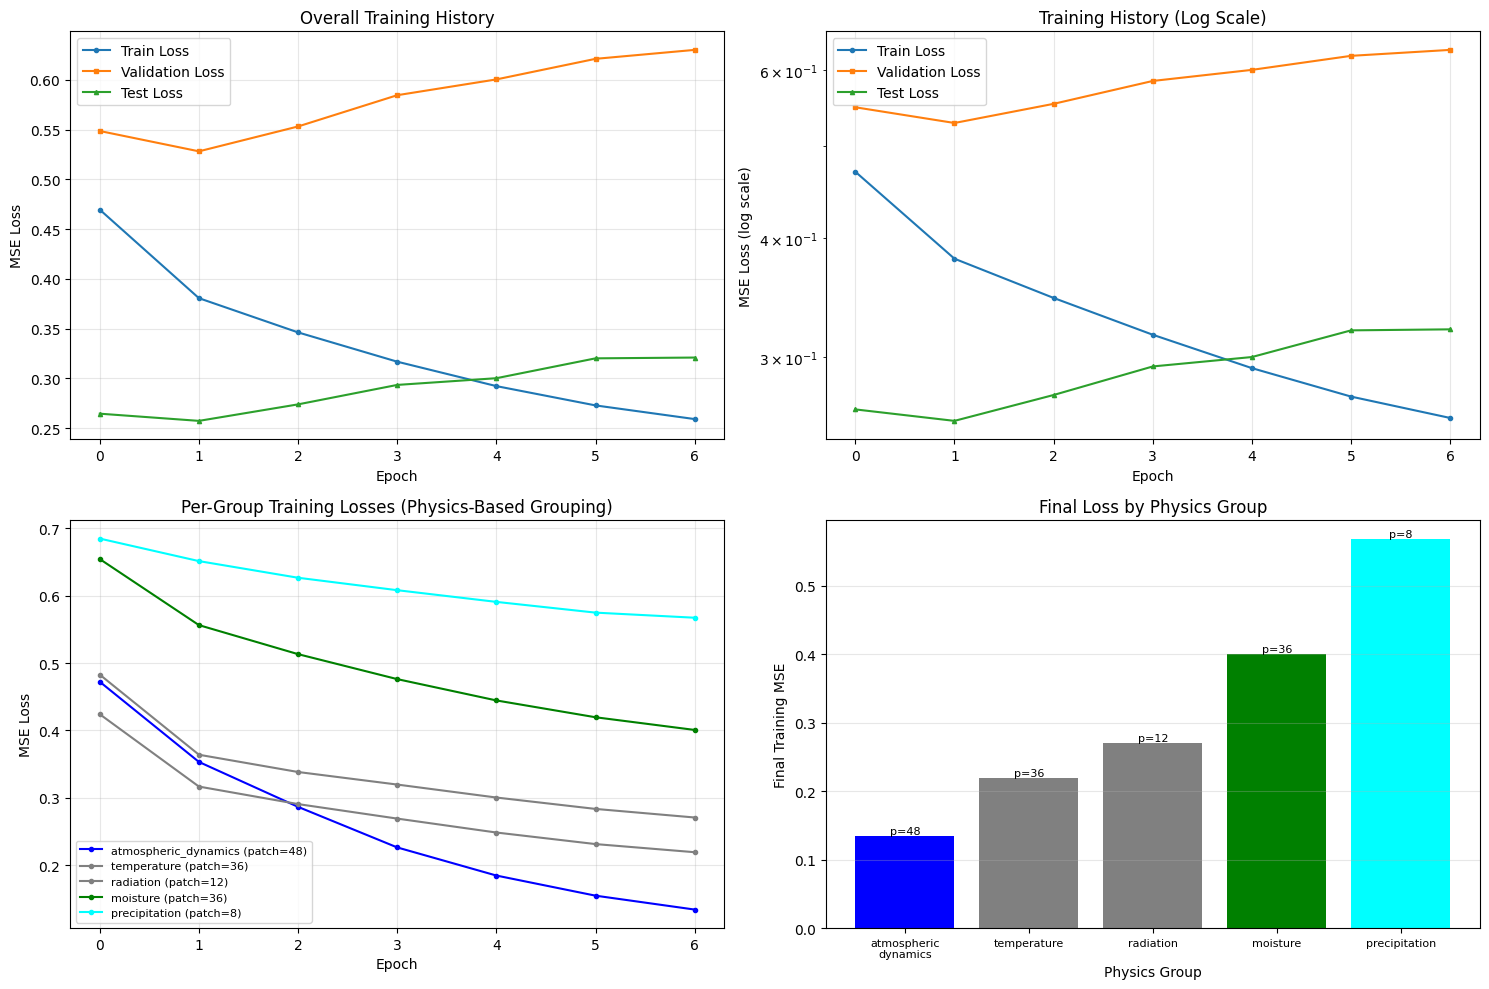

In [178]:
# Plot training history with per-group breakdown
if os.path.exists(dataset_path) and len(train_losses) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall training curves
    axes[0, 0].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 0].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 0].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].set_title('Overall Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Log scale
    axes[0, 1].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 1].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 1].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE Loss (log scale)')
    axes[0, 1].set_title('Training History (Log Scale)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Per-group training losses (Physics-based colors)
    colors = {
        'atmospheric_dynamics': 'blue',
        'thermodynamics': 'red',
        'moisture': 'green',
        'precipitation': 'cyan',
        'temporal': 'purple'
    }
    for group_name, losses in group_train_losses.items():
        if len(losses) > 0:
            patch_len = args.patch_configs[group_name]['patch_len']
            color = colors.get(group_name, 'gray')
            axes[1, 0].plot(losses, label=f'{group_name} (patch={patch_len})', 
                           color=color, marker='o', markersize=3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].set_title('Per-Group Training Losses (Physics-Based Grouping)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Final per-group comparison (bar chart)
    first_group = list(group_train_losses.keys())[0]
    if len(group_train_losses[first_group]) > 0:
        group_names = list(group_train_losses.keys())
        final_losses = [group_train_losses[name][-1] for name in group_names]
        patch_lens = [args.patch_configs[name]['patch_len'] for name in group_names]
        
        bars = axes[1, 1].bar(range(len(group_names)), final_losses, 
                              color=[colors.get(n, 'gray') for n in group_names])
        axes[1, 1].set_xticks(range(len(group_names)))
        axes[1, 1].set_xticklabels([n.replace('_', '\n') for n in group_names], fontsize=8)
        axes[1, 1].set_xlabel('Physics Group')
        axes[1, 1].set_ylabel('Final Training MSE')
        axes[1, 1].set_title('Final Loss by Physics Group')
        
        # Add patch length annotations
        for bar, pl in zip(bars, patch_lens):
            axes[1, 1].annotate(f'p={pl}', 
                               xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                               ha='center', va='bottom', fontsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 6. Model Checkpointing <a id='checkpointing'></a>

Learn how to save and load model checkpoints.

In [179]:
# Save model checkpoint with additional information
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'config': vars(args)
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to: {filepath}")

# Save current model
if os.path.exists(dataset_path):
    custom_checkpoint_path = os.path.join(checkpoint_path, 'model_final.pth')
    save_checkpoint(
        model, 
        optimizer, 
        args.train_epochs,
        train_losses[-1] if train_losses else 0,
        val_losses[-1] if val_losses else 0,
        custom_checkpoint_path
    )

Checkpoint saved to: /home/hkrishnamoorthy/projects/Capstone/PatchTST/PatchTST_supervised/models/checkpoints_physics_hour/PhysicsIntegrated_custom_sl512_pl336/model_final.pth


In [180]:
# Load model checkpoint
def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', None)
    val_loss = checkpoint.get('val_loss', None)
    
    print(f"Checkpoint loaded from: {filepath}")
    print(f"  Epoch: {epoch}")
    if train_loss is not None:
        print(f"  Train Loss: {train_loss:.7f}")
    if val_loss is not None:
        print(f"  Val Loss: {val_loss:.7f}")
    
    return model, optimizer, epoch

# Example: Load the saved checkpoint
if os.path.exists(dataset_path):
    if os.path.exists(custom_checkpoint_path):
        model, optimizer, epoch = load_checkpoint(custom_checkpoint_path, model, optimizer)
    else:
        print("No checkpoint found to load.")

Checkpoint loaded from: /home/hkrishnamoorthy/projects/Capstone/PatchTST/PatchTST_supervised/models/checkpoints_physics_hour/PhysicsIntegrated_custom_sl512_pl336/model_final.pth
  Epoch: 100
  Train Loss: 0.2590573
  Val Loss: 0.6300003


## 7. Evaluation and Visualization <a id='evaluation'></a>

Evaluate the model on the test set and visualize predictions.

In [181]:
# Comprehensive evaluation with per-group analysis (21 weather channels only)
def evaluate_physics_integrated_model(model, test_loader, device, args):
    """
    Optimized evaluation function with a progress indicator.
    Calculates metrics iteratively and returns the first batch for visualization.
    """
    model.eval()
    
    # Store first batch for visualization
    first_batch_preds = None
    first_batch_trues = None
    first_batch_inputs = None
    
    # Iterative metrics calculation
    total_samples = 0
    total_mse = 0
    total_mae = 0
    
    # Per-group iterative metrics
    group_metrics = {
        group_name: {'mse': 0, 'mae': 0, 'samples': 0} 
        for group_name in args.channel_groups.keys()
    }

    print("Starting evaluation...") # Initial message
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            
            # --- Progress Indicator ---
            if (i + 1) % 50 == 0:
                print(f"  Evaluating batch {i + 1}/{len(test_loader)}...")

            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            # Forward pass
            outputs = model(batch_x)
            
            # Slice to get weather channels
            outputs_weather = outputs[:, -args.pred_len:, :args.c_out]
            batch_y_weather = batch_y[:, -args.pred_len:, :args.c_out]
            
            # --- Store first batch for visualization ---
            if i == 0:
                first_batch_preds = outputs_weather.detach().cpu().numpy()
                first_batch_trues = batch_y_weather.detach().cpu().numpy()
                first_batch_inputs = batch_x.detach().cpu().numpy()

            # --- Iterative metrics calculation ---
            batch_size = batch_x.shape[0]
            total_samples += batch_size
            
            # Overall metrics
            total_mse += F.mse_loss(outputs_weather, batch_y_weather, reduction='sum').item()
            total_mae += F.l1_loss(outputs_weather, batch_y_weather, reduction='sum').item()
            
            # Per-group metrics
            for group_name in args.channel_groups.keys():
                info = model.group_info[group_name]
                weather_indices = info['weather_indices']
                
                if len(weather_indices) > 0:
                    group_preds = outputs_weather[:, :, weather_indices]
                    group_trues = batch_y_weather[:, :, weather_indices]
                    
                    group_metrics[group_name]['mse'] += F.mse_loss(group_preds, group_trues, reduction='sum').item()
                    group_metrics[group_name]['mae'] += F.l1_loss(group_preds, group_trues, reduction='sum').item()
                    group_metrics[group_name]['samples'] += batch_size * group_preds.shape[1] * group_preds.shape[2]

    # --- Finalize metrics ---
    final_mse = total_mse / (total_samples * args.pred_len * args.c_out)
    final_mae = total_mae / (total_samples * args.pred_len * args.c_out)
    final_rmse = np.sqrt(final_mse)
    
    print("\n" + "=" * 70)
    print("Physics-Integrated PatchTST - Test Set Evaluation (Optimized)")
    print("=" * 70)
    print(f"\nOVERALL METRICS (21 weather channels):")
    print(f"  MSE:  {final_mse:.7f}")
    print(f"  MAE:  {final_mae:.7f}")
    print(f"  RMSE: {final_rmse:.7f}")
    
    # Finalize per-group metrics
    final_group_metrics = {}
    print(f"\nPER-GROUP METRICS (weather channels only):")
    for group_name, data in group_metrics.items():
        if data['samples'] > 0:
            g_mse = data['mse'] / data['samples']
            g_mae = data['mae'] / data['samples']
            g_rmse = np.sqrt(g_mse)
            
            final_group_metrics[group_name] = {'mse': g_mse, 'mae': g_mae, 'rmse': g_rmse}
            
            info = model.group_info[group_name]
            patch_len = args.patch_configs[group_name]['patch_len']
            hour_str = "+hour" if len(info['hour_indices']) > 0 else ""
            
            print(f"\n  {group_name.upper()} (patch={patch_len}, {len(info['weather_indices'])} weather{hour_str}):")
            print(f"    MSE:  {g_mse:.7f}")
            print(f"    MAE:  {g_mae:.7f}")
            print(f"    RMSE: {g_rmse:.7f}")
    
    print("=" * 70)
    
    # Return first batch for plotting and final metrics
    return first_batch_preds, first_batch_trues, first_batch_inputs, {'overall': {'mse': final_mse, 'mae': final_mae}, 'groups': final_group_metrics}

# Run evaluation
if os.path.exists(dataset_path):
    preds, trues, inputs, metrics = evaluate_physics_integrated_model(model, test_loader, device, args)

Starting evaluation...
  Evaluating batch 50/318...
  Evaluating batch 100/318...
  Evaluating batch 150/318...
  Evaluating batch 200/318...
  Evaluating batch 250/318...
  Evaluating batch 300/318...

Physics-Integrated PatchTST - Test Set Evaluation (Optimized)

OVERALL METRICS (21 weather channels):
  MSE:  0.2572581
  MAE:  0.2971332
  RMSE: 0.5072062

PER-GROUP METRICS (weather channels only):

  ATMOSPHERIC_DYNAMICS (patch=48, 4 weather):
    MSE:  0.3238027
    MAE:  0.3664291
    RMSE: 0.5690367

  TEMPERATURE (patch=36, 6 weather+hour):
    MSE:  0.2873603
    MAE:  0.2757575
    RMSE: 0.5360600

  RADIATION (patch=12, 2 weather+hour):
    MSE:  0.0310038
    MAE:  0.1017594
    RMSE: 0.1760789

  MOISTURE (patch=36, 7 weather+hour):
    MSE:  0.2921578
    MAE:  0.3592112
    RMSE: 0.5405163

  PRECIPITATION (patch=8, 2 weather+hour):
    MSE:  0.1379674
    MAE:  0.2007699
    RMSE: 0.3714396


In [182]:
def evaluate_model_fast(model, test_loader, device, args, max_batches=None):
    """
    Fast evaluation with detailed progress tracking.

    Note: This physics-integrated model uses hour_sin/hour_cos already inside batch_x,
    so we ignore batch_x_mark/batch_y_mark from the loader.
    """
    model.eval()
    preds = []
    trues = []
    inputs = []

    print("Starting evaluation...")
    print(f"  Device: {device}")
    print(f"  Model: {model.__class__.__name__}")

    batch_count = 0
    try:
        with torch.no_grad():
            for batch_x, batch_y, *_ in test_loader:
                batch_count += 1
                print(f"  [{batch_count}] Loading batch...", end="", flush=True)

                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)
                print(" Forward pass...", end="", flush=True)

                # Forward pass
                try:
                    # Model expects [B, seq_len, enc_in] where enc_in matches batch_x last-dim.
                    result = model(batch_x)
                    outputs = result[0] if isinstance(result, tuple) else result
                except Exception as e:
                    print(f"\n    ERROR in forward pass: {str(e)[:150]}")
                    raise

                print(" Post-process...", end="", flush=True)

                # Extract predictions (model outputs 21 weather channels)
                outputs = outputs[:, -args.pred_len:, :]
                batch_y = batch_y[:, -args.pred_len:, :args.c_out]

                # Store results
                preds.append(outputs.detach().cpu().numpy())
                trues.append(batch_y.detach().cpu().numpy())
                inputs.append(batch_x.detach().cpu().numpy())

                print(" Done!")

                if max_batches and batch_count >= max_batches:
                    print(f"  Reached max_batches limit ({max_batches})")
                    break

    except KeyboardInterrupt:
        print("\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Evaluation failed at batch {batch_count}: {str(e)}")
        raise

    print(f"\n✓ Evaluation complete! Processed {batch_count} batches")

    if len(preds) == 0:
        print("❌ ERROR: No predictions collected!")
        return None, None, None, None

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    inputs = np.concatenate(inputs, axis=0)

    print("\nConsolidated data shapes:")
    print(f"  preds: {preds.shape}")
    print(f"  trues: {trues.shape}")
    print(f"  inputs: {inputs.shape}")

    print("\nCalculating metrics...")
    mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)

    print("\n" + "="*70)
    print("TEST SET EVALUATION METRICS")
    print("="*70)
    print(f"  MSE:  {mse:.7f}")
    print(f"  MAE:  {mae:.7f}")
    print(f"  RMSE: {rmse:.7f}")
    print(f"  MAPE: {mape:.7f}")
    print(f"  MSPE: {mspe:.7f}")
    print(f"  RSE:  {rse:.7f}")
    if isinstance(corr, np.ndarray):
        print(f"  CORR: {np.mean(corr):.7f} (mean)")
    else:
        print(f"  CORR: {corr:.7f}")
    print("="*70)

    return preds, trues, inputs, {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'mspe': mspe,
        'rse': rse,
        'corr': corr
    }

# Run evaluation
if os.path.exists(dataset_path):
    print("\n" + "="*70)
    print("STARTING MODEL EVALUATION")
    print("="*70)

    preds, trues, inputs, metrics = evaluate_model_fast(model, test_loader, device, args, max_batches=None)

    if preds is not None:
        print("\n✓ Evaluation successful!")
    else:
        print("\n❌ Evaluation failed - no data collected")


STARTING MODEL EVALUATION
Starting evaluation...
  Device: cuda:0
  Model: LearnablePatchLengthModel
  [1] Loading batch... Forward pass... Post-process... Done!
  [2] Loading batch... Forward pass... Post-process... Done!
  [3] Loading batch... Forward pass... Post-process... Done!
  [4] Loading batch... Forward pass... Post-process... Done!
  [5] Loading batch... Forward pass... Post-process... Done!
  [6] Loading batch... Forward pass... Post-process... Done!
  [7] Loading batch... Forward pass... Post-process... Done!
  [8] Loading batch... Forward pass... Post-process... Done!
  [9] Loading batch... Forward pass... Post-process... Done!
  [10] Loading batch... Forward pass... Post-process... Done!
  [11] Loading batch... Forward pass... Post-process... Done!
  [12] Loading batch... Forward pass... Post-process... Done!
  [13] Loading batch... Forward pass... Post-process... Done!
  [14] Loading batch... Forward pass... Post-process... Done!
  [15] Loading batch... Forward pass...

preds shape: (10176, 336, 21), trues shape: (10176, 336, 21)


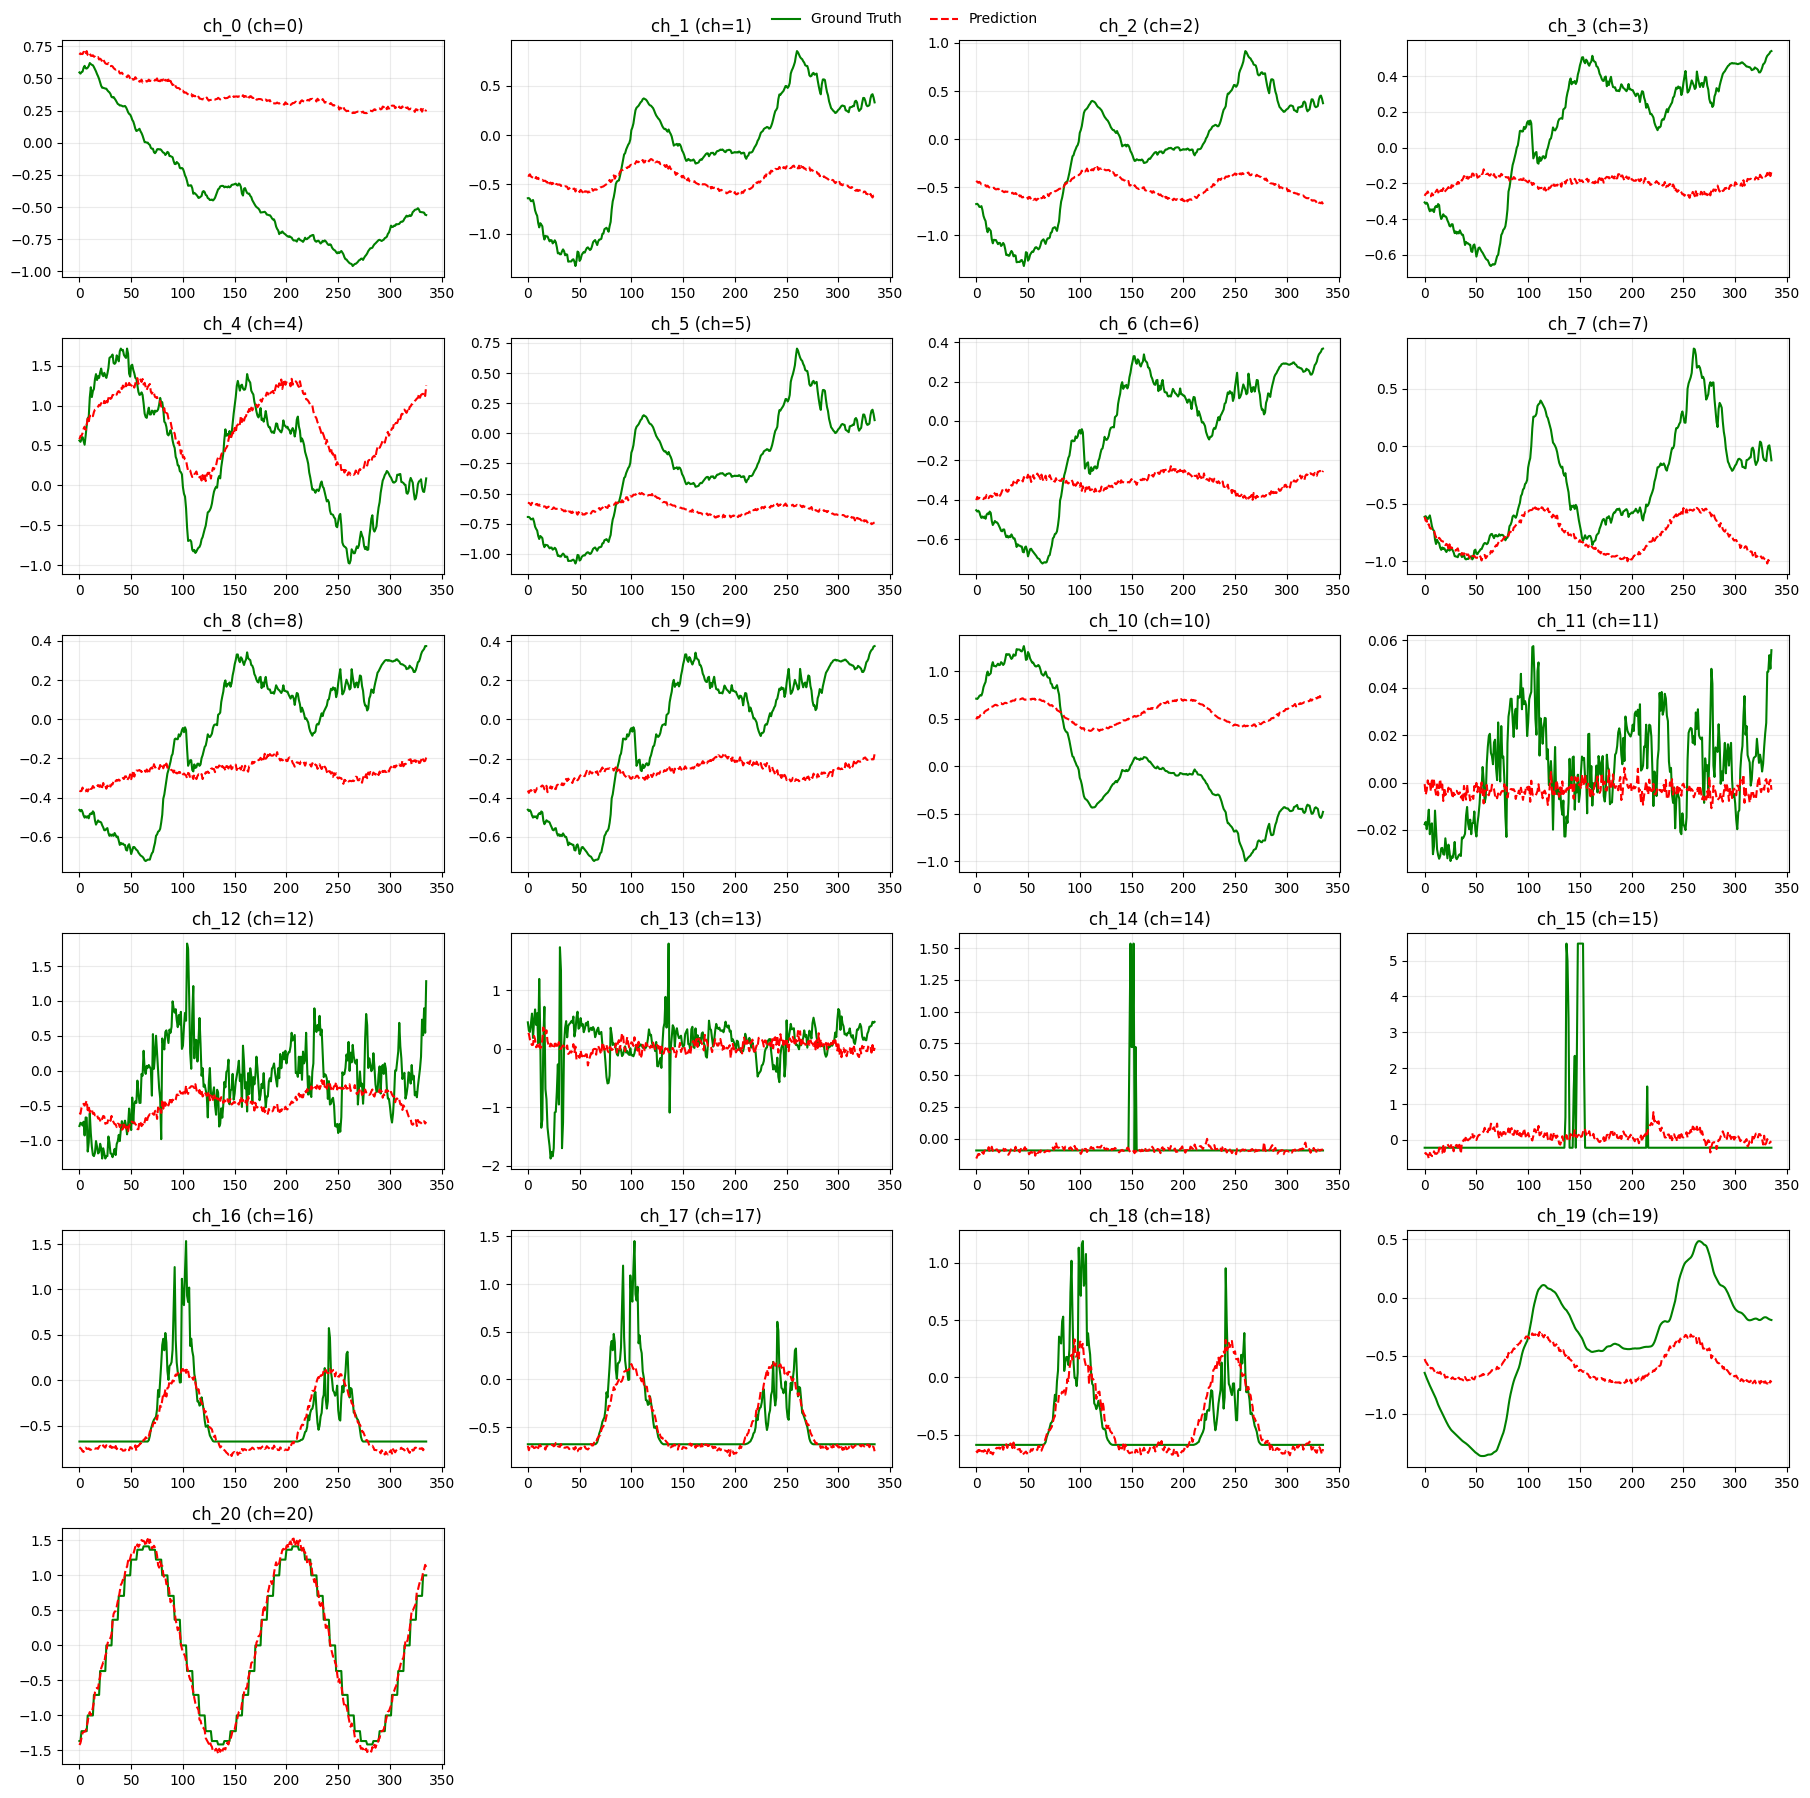

In [183]:
# Visualize predictions: Ground Truth vs Prediction (all channels)
%matplotlib inline

def _get_channel_names(n_channels: int):
    """Best-effort channel naming if WEATHER_CHANNELS exists."""
    try:
        if isinstance(WEATHER_CHANNELS, dict):
            names = [None] * n_channels
            for k, idx in WEATHER_CHANNELS.items():
                idx = int(idx)
                if 0 <= idx < n_channels:
                    names[idx] = str(k)
            if any(n is not None for n in names):
                return [n if n is not None else f"ch_{i}" for i, n in enumerate(names)]
    except Exception:
        pass
    return [f"ch_{i}" for i in range(n_channels)]


def plot_gt_vs_pred_all_channels(trues, preds, num_samples=3, ncols=4, channel_names=None):
    """Plot Ground Truth vs Prediction for every channel.

    trues/preds: [N, pred_len, C]
    """
    n_samples = min(num_samples, trues.shape[0], preds.shape[0])
    c_out = min(trues.shape[-1], preds.shape[-1])

    if channel_names is None:
        channel_names = _get_channel_names(c_out)
    else:
        channel_names = list(channel_names)[:c_out]

    nrows = int(np.ceil(c_out / ncols))
    t = np.arange(trues.shape[1])

    figs = []
    for i in range(n_samples):
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3.0 * nrows), squeeze=False)

        for ch in range(c_out):
            r, c = divmod(ch, ncols)
            ax = axes[r][c]

            ax.plot(t, trues[i, :, ch], 'g-', label='Ground Truth', linewidth=1.5)
            ax.plot(t, preds[i, :, ch], 'r--', label='Prediction', linewidth=1.5)

            title = channel_names[ch] if ch < len(channel_names) else f"ch_{ch}"
            ax.set_title(f"{title} (ch={ch})")
            ax.grid(True, alpha=0.25)

        # Turn off unused axes
        for k in range(c_out, nrows * ncols):
            r, c = divmod(k, ncols)
            axes[r][c].axis('off')

        # One shared legend
        handles, labels = axes[0][0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
        #fig.suptitle(f"Sample {i + 1}: Ground Truth vs Prediction", y=1.01)
        plt.tight_layout()
        figs.append(fig)

    return figs


print(f"preds shape: {preds.shape}, trues shape: {trues.shape}")
_ = plot_gt_vs_pred_all_channels(trues, preds, num_samples=1, ncols=4)
plt.show()

Error stats - mean: -0.001219, std: 0.507205


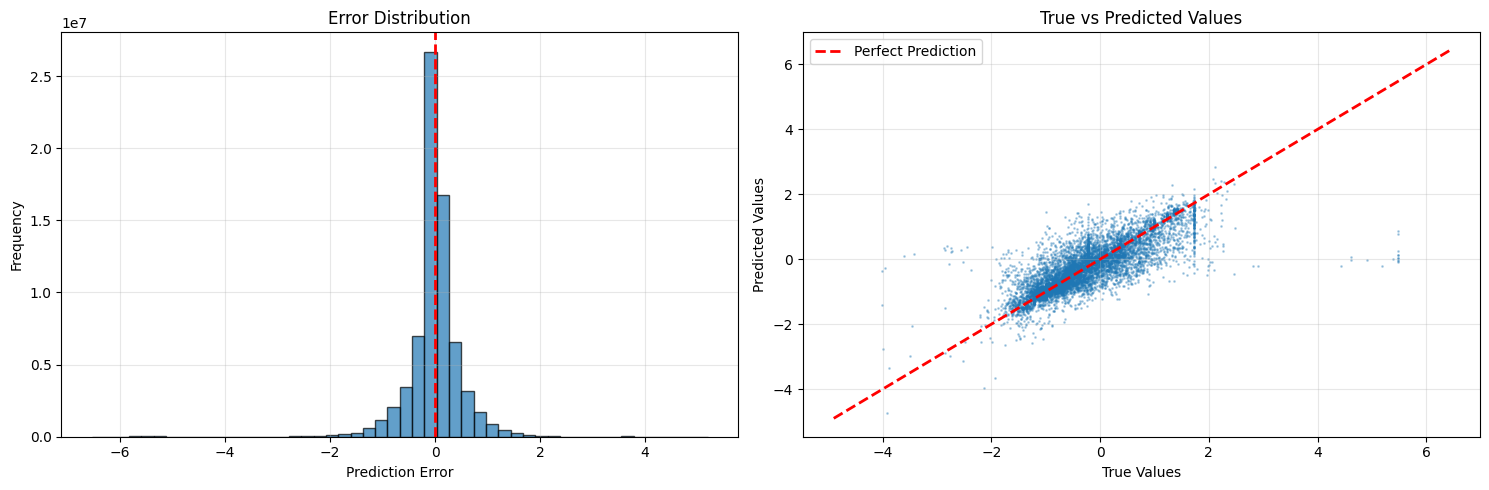

In [184]:
# Plot prediction error distribution
%matplotlib inline

errors = preds - trues
print(f"Error stats - mean: {errors.mean():.6f}, std: {errors.std():.6f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error distribution
axes[0].hist(errors.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

# Scatter plot: True vs Predicted
sample_size = min(10000, preds.size)
idx = np.random.choice(preds.size, sample_size, replace=False)
axes[1].scatter(trues.flatten()[idx], preds.flatten()[idx], alpha=0.3, s=1)

# Add perfect prediction line
min_val = min(trues.flatten().min(), preds.flatten().min())
max_val = max(trues.flatten().max(), preds.flatten().max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('True vs Predicted Values')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Per-Channel Performance:
Channel    Name                 MSE             MAE             RMSE           
0          p (mbar)             0.7822576       0.6167796       0.8844533      
1          T (degC)             0.2000247       0.3291463       0.4472412      
2          Tpot (K)             0.2140855       0.3384826       0.4626938      
3          rh (%)               0.2384497       0.3683659       0.4883131      
4          VPmax (mbar)         0.3692948       0.4795974       0.6076963      
5          VPact (mbar)         0.1217459       0.2424528       0.3489211      
6          VPdef (mbar)         0.2027640       0.3252270       0.4502932      
7          wv (m/s)             0.0628931       0.1770940       0.2507850      
8          max. wv (m/s)        0.2246340       0.3354298       0.4739557      
9          wd (deg)             0.2254261       0.3364133       0.4747905      
10         rain (mm)            0.2751641       0.3799305       0.5245609      
11         rai

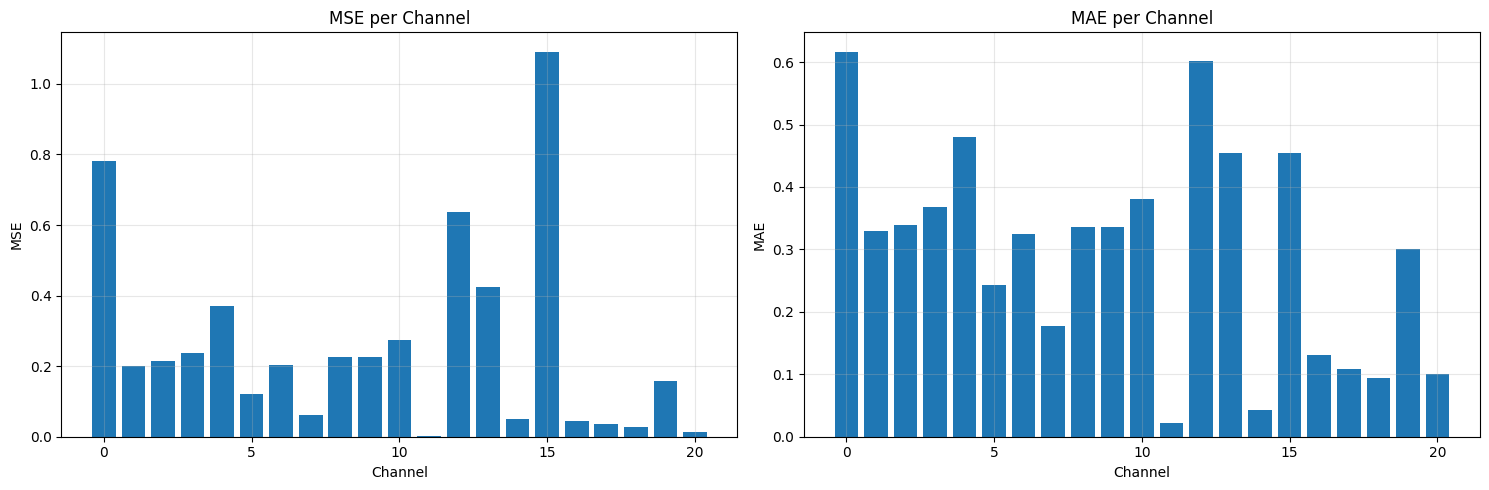

In [185]:
# Per-channel performance analysis (ordered by channel index, like PatchTST_Original)
%matplotlib inline

num_channels = preds.shape[-1]  # 21 weather channels
channel_metrics = []

# Channel names from WEATHER_CHANNELS (ordered 0-20)
channel_names = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'rh (%)', 'VPmax (mbar)', 
    'VPact (mbar)', 'VPdef (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)',
    'rain (mm)', 'raining (s)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)',
    'Tdew (degC)', 'Tlog (degC)', 'CO2 (ppm)', 'PAR (μmol/m²/s)', 'Tmax (degC)', 'Tmin (degC)'
]

print("\nPer-Channel Performance:")
print("=" * 80)
print(f"{'Channel':<10} {'Name':<20} {'MSE':<15} {'MAE':<15} {'RMSE':<15}")
print("=" * 80)

for ch in range(num_channels):
    ch_pred = preds[:, :, ch]
    ch_true = trues[:, :, ch]
    
    ch_mse = np.mean((ch_pred - ch_true) ** 2)
    ch_mae = np.mean(np.abs(ch_pred - ch_true))
    ch_rmse = np.sqrt(ch_mse)
    
    ch_name = channel_names[ch] if ch < len(channel_names) else f'Ch{ch}'
    channel_metrics.append({'channel': ch, 'name': ch_name, 'mse': ch_mse, 'mae': ch_mae, 'rmse': ch_rmse})
    print(f"{ch:<10} {ch_name:<20} {ch_mse:<15.7f} {ch_mae:<15.7f} {ch_rmse:<15.7f}")

print("=" * 80)

# Visualize channel performance
channels = [m['channel'] for m in channel_metrics]
mses = [m['mse'] for m in channel_metrics]
maes = [m['mae'] for m in channel_metrics]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(channels, mses)
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE per Channel')
axes[0].grid(True, alpha=0.3)

axes[1].bar(channels, maes)
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE per Channel')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()